# Training of the different Recurrent Neural Networks Models

In [1]:
import sys
# setting path
sys.path.append("C:/Users/abderrahim.namouh/Documents/OneDrive - Mazars/Projet/uniswap-v3")

import pandas as pd
from Strat_backtesting_env import LiquidityPool
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np


In [2]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [3]:
device =  device = torch.device("cpu")  # torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Price Path Simulation according to the Contrat-Market price process, modeling and interaction between Binance and Uniswap exchanges

In [4]:
def simulate_market_prices(T, mu, sigma, S0):
    prices = np.zeros(T + 1)  # Pre-allocate
    prices[0] = S0
    noise = np.random.randn(T).astype(np.float16)  # Pre-generate random noise
    drift = (mu - 0.5 * sigma**2)
    volatility = sigma

    for t in range(1, T + 1):
        prices[t] = prices[t - 1] * np.exp(drift + volatility * noise[t - 1])
    return prices

# Step 2: Simulate Contract Prices with Non-Arbitrage and Arbitrage Trades following our Contract-Market Price modeling
def simulate_contract_prices(market_prices, gamma, lambda_val, kr):
    contract_prices = [market_prices[0]]
    realized_market_prices = [market_prices[0]]

    # For each round defined as the in-btween of two market price changes
    for t in range(0, len(market_prices)):
        P_c = contract_prices[- 1]
        P_m = market_prices[t]
        
        # We check if the new market price triggers an arbitrage
        if P_c < (1 - gamma) * P_m:
            P_c = (1 - gamma) * P_m
            contract_prices.append(P_c)
            realized_market_prices.append(P_m)
            
        elif P_c >  P_m / (1 - gamma):
            P_c = P_m / (1 - gamma)
            contract_prices.append(P_c)
            realized_market_prices.append(P_m)

        # Adverse Trades
        for _ in range(kr):
            direction = 1 if random.random() > 0.5 else -1
            P_c *= (1 + lambda_val)**(direction)
            contract_prices.append(P_c)
            realized_market_prices.append(P_m)
            
            # Checking for arbitrage
            if P_c < (1 - gamma) * P_m:
                P_c = (1 - gamma) * P_m
                contract_prices.append(P_c)
                realized_market_prices.append(P_m)

            elif P_c >  P_m / (1 - gamma):
                P_c = P_m / (1 - gamma)
                contract_prices.append(P_c)
                realized_market_prices.append(P_m)

    return realized_market_prices, contract_prices

# Step 3: Full Simulation Loop
def run_simulation(T, mu, sigma, S0, gamma, lambda_val, kr):
    market_prices = simulate_market_prices(T, mu, sigma, S0)
    realized_market_prices, contract_prices = simulate_contract_prices(market_prices, gamma, lambda_val, kr)
    return realized_market_prices, contract_prices

In [66]:
# Genrate future scenarios for a numer of price histories and save it as a CSV

def generate_price_data_for_csv(num_histories, num_scenarios, T, mu, sigma, price_range):
    data = []
    
    for history_id in range(num_histories):

        # Randomly generate initial price
        S0 = np.random.randint(price_range[0], price_range[1])
        gamma, lambda_val, kr = 0.0005, np.random.normal(0.00005,0.0011), abs(int(np.random.normal(4, 2)))

        # Generate initial price history (64 historical prices)
        price_history = run_simulation(600, mu, sigma, S0, gamma, lambda_val, kr)[1]
        
        # Store the historical path with an identifier
        data.append({
            'ID': history_id,
            'Type': 'history',
            'Prices': ','.join(map(str, price_history[-600:]))
        })
        
        # Generate future scenarios
        for scenario_id in range(num_scenarios):
            future_path = run_simulation(T, mu, sigma, price_history[-1], gamma, lambda_val, kr)[1]
            
            # Store each scenario associated with the same historical path
            data.append({
                'ID': history_id,
                'Type': f'scenario_{scenario_id}',
                'Prices': ','.join(map(str, future_path))
            })
        
        price_history = run_simulation(600, -mu, sigma, S0, gamma, lambda_val, kr)[1]
        
        # Store the historical path with an identifier
        data.append({
            'ID': history_id,
            'Type': 'history',
            'Prices': ','.join(map(str, price_history[-600:]))
        })
        
        # Generate future scenarios
        for scenario_id in range(num_scenarios):
            future_path = run_simulation(T, -mu, sigma, price_history[-1], gamma, lambda_val, kr)[1]
            
            # Store each scenario associated with the same historical path
            data.append({
                'ID': history_id,
                'Type': f'scenario_{scenario_id}',
                'Prices': ','.join(map(str, future_path))
            })
            

    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(data)

    df.to_csv('../../price_data.csv', index=False)

generate_price_data_for_csv(num_histories=300, num_scenarios=50, T=1440, mu=0.00001, sigma=0.0011, price_range=(1000, 5000))


In [139]:
# Generate price paths (without any history) this will be used in the Robust RNN model
from scipy.stats import truncnorm
def generate_price_paths(file_name, num_paths, T, mu, sigma, price_range):
    data = []
    
    for path_id in range(num_paths):
        if path_id % 10 == 0:
        
        a = (0-4)/2
        b = np.inf
        # Randomly generate initial price
        S0 = np.random.randint(price_range[0], price_range[1])
        gamma, lambda_val, kr = 0.0005, np.random.uniform(0.00001,0.00009), int(truncnorm.rvs(a,b, loc=4, scale=2, size=1)[0])

        # Generate price path
        price_path = run_simulation(T, mu, sigma, S0, gamma, lambda_val, kr)[1]
        
        # Store 
        data.append({
            'ID': path_id,
            'Prices': ','.join(map(str, price_path))
        })

    df = pd.DataFrame(data)

    df.to_csv(file_name, index=False)

In [ ]:
file_name = '../../single_price_paths.csv'
num_paths = 1000
T = 1440
mu = 0.000006
sigma = 0.0011
price_range = (2000,5000)
generate_price_paths(file_name, num_paths, T, mu, sigma, price_range) # Simulate and save single price paths

In [6]:
# For loading from a csv file
def load_history_price_data(csv_file):
    df = pd.read_csv(csv_file)
    
    # Group by ID to get the historical path and its scenarios
    data_dict = {}
    for history_id, group in df.groupby('ID'):
        history = None
        scenarios = []
        
        for _, row in group.iterrows():
            if row['Type'] == 'history':
                history = np.array(list(map(float, row['Prices'].split(','))))
            else:
                scenario = np.array(list(map(float, row['Prices'].split(','))))
                scenarios.append(scenario)
        
        # Store history and scenarios in a dictionary
        data_dict[history_id] = {
            'history': history,
            'scenarios': scenarios  # Keep this as a list of arrays to handle variable lengths
        }
    
    return data_dict

data = load_history_price_data('../../price_data.csv')

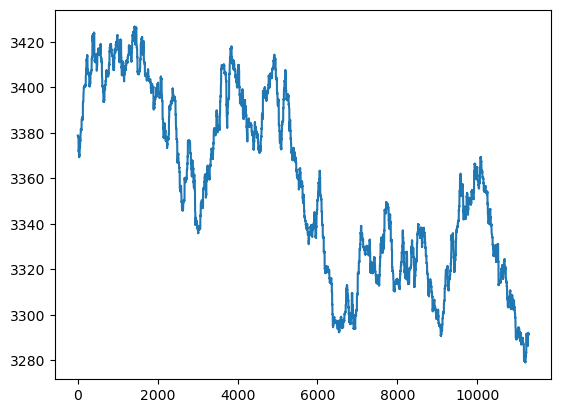

In [70]:
plt.plot(data[0]['scenarios'][8])

In [5]:
# For loading from a csv file
def load_single_price_data(csv_file):
    df = pd.read_csv(csv_file)
    
    data_dict = {}
    for idx , row in df.iterrows():
        scenario = np.array(list(map(float, row['Prices'].split(','))))
        data_dict[idx] = scenario
    
    return data_dict

single_price_paths = load_single_price_data('../../single_price_paths.csv')

#### Useful functions

In [6]:
# utility function used for monitoring risk aversion
def utility(a, r):
    return (1-torch.exp(-a*r))/a if a !=0 else r

# Allocation buckets
def generate_buckets(num_buckets, start_price, phi = 1.0001**10):
    central_value = int(np.log(start_price) / np.log(phi))
    return [phi ** (central_value + i) for i in range(-num_buckets, num_buckets + 2)]

# Evaluating the pool (this is just a vector to be multiplied by the weights to get the actual eval)
def evaluate(pool, wealth , bins):
    val = []
    for i in range(len(bins)-1):
        token0, token1 = pool.get_position_comp(bins[i], bins[i+1])
        token0 += pool.get_position_fees(bins[i], bins[i+1], 0)-pool.positions[bins[i], bins[i+1]][f'fg_last_0']
        token1 += pool.get_position_fees(bins[i], bins[i+1], 1)-pool.positions[bins[i], bins[i+1]][f'fg_last_1']
        val.append(token1 + token0 * pool.current_price)
    val.append(wealth)
    return val

# Get the amount of each token present in the pool
def initial_comp(pool, wealth , weights, bins):
    comps0, comps1 = [], []

    for i in range(len(bins)-1):
        token0, token1 = pool.get_position_comp(bins[i], bins[i+1])
        comps0.append(token0)
        comps1.append(token1)

    comps0.append(0) # 0 cash in tokens0
    comps1.append(wealth) # a certain amount to be defined by the weight

    comps0, comps1 = torch.tensor(comps0, dtype=torch.float32), torch.tensor(comps1, dtype=torch.float32)

    return torch.dot(comps0, weights), torch.dot(comps1, weights)


### Simple RNN without reallocations

In [78]:
class SimpleRNNAllocationNetwork(nn.Module):
    def __init__(self, tau, input_size=1, hidden_size=16, num_hidden_layers=2):
        super(SimpleRNNAllocationNetwork, self).__init__()
        self.tau = tau
        self.hidden_size = hidden_size
        self.num_hidden_layers = num_hidden_layers

        # RNN Layer 
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_hidden_layers, batch_first=True, dropout=0.2)
        
        # Output layer to map RNN's hidden state to allocation weights
        self.output_layer = nn.Linear(hidden_size, 2 * tau + 2)  # Output size depends on tau
        self.softmax = nn.Softmax(dim=-1)  # Normalize the allocation weights
    
    def forward(self, x):
        # Initialize the hidden state (batch_size, num_layers, hidden_size)
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_hidden_layers, batch_size, self.hidden_size).to(x.device)  # RNN's initial hidden state
        
        # Forward pass through RNN
        rnn_out, _ = self.rnn(x, h0)  # rnn_out: (batch_size, seq_length, hidden_size)
        
        # Use the last hidden state to predict allocation weights
        final_hidden_state = rnn_out[:, -1, :]  # (batch_size, hidden_size)
        
        # Pass through the output layer
        output = self.output_layer(final_hidden_state)  # (batch_size, output_size)
        
        # Apply softmax to ensure the weights sum to 1
        weights = self.softmax(output)
        return weights.squeeze()

def SimpleRNN_train_model(model, tau, a, fee_tier, num_epochs=100, num_history=100, batch_size=50, lr=0.001, device='cpu'):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []
    for epoch in range(num_epochs):
        for history_id in range(num_history):
            optimizer.zero_grad()
            wealth = 1000 # not relevent since we are optimizing the IL+fees (a ratio)
            # Randomly generate initial price and wealth
            history = data[history_id]['history'][:60]

            # Prepare context input (reshape price_path0 to match RNN input)
            context_input = torch.tensor(history, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
            # Shape of context_input: (batch_size=1, seq_length=64, input_size=1)
            
            # Get the weights from the model
            weights = model(context_input)
            # Create the liquidity pool and bins

            pool = LiquidityPool(history[-1], fee_tier)
            bins = generate_buckets(tau, history[-1])
            pool.add_allocation(wealth, np.ones(len(bins)), bins)

            # Compute initial token composition
            ini_token0, ini_token1 = initial_comp(pool, wealth, weights, bins)

            rewards = []

            for path_id in range(batch_size):  # Train on multiple scenarios for each history_id

                pool = LiquidityPool(history[-1], fee_tier)
                # Add allocation to the liquidity pool
                pool.add_allocation(0.99, np.ones(len(bins)), bins)

                price_path = data[history_id]["scenarios"][path_id]
                # Simulate swaps within the pool based on the price path
                idx = 1
                while idx < len(price_path) and price_path[idx] < bins[-1] and price_path[idx] > bins[0]:
                    pool.swap_price(price_path[idx])
                    idx += 1

                # Evaluate LP strategy
                reward = evaluate(pool, 1, bins)

                # Convert reward to tensor and calculate relative performance
                reward = torch.tensor(reward, dtype=torch.float32).to(device)
                
                rewards.append(reward)
                
            # Calculate hold value (no LP strategy)
            hold_val = ini_token0 * pool.current_price + ini_token1
            
            # Compute the total reward (mean over all scenarios)
            total_reward = wealth * torch.mean(torch.stack(rewards), dim=0)
            total_reward = torch.dot(weights, total_reward)
            total_reward  = (total_reward - hold_val) / hold_val

            # Use the total reward as the objective (loss is negative reward)
            loss = -utility(a,total_reward)
            
            losses.append(loss.item())
            # Backpropagation
            loss.backward()
            optimizer.step()
            
        writer.add_scalar("Loss/train", loss, epoch)
        # Print progress every few epochs
        if epoch % 1 == 0:
            print(f"Epoch {epoch}, Loss: {np.mean(losses[epoch*num_history:(epoch+1)*num_history])}")
    return losses

In [79]:
tau = 20
hidden_size = 16
SimpleRNNmodel = SimpleRNNAllocationNetwork(tau=tau, hidden_size=hidden_size).to(device)
fee_tier = 0.05
a = 0
# Train the model
losses_simple = SimpleRNN_train_model(SimpleRNNmodel, tau, a, fee_tier, num_epochs=20, num_history=100, batch_size=50, lr=0.01)
writer.flush()

Epoch 0, Loss: 0.006784158623413532
Epoch 1, Loss: 0.0036071712599368764
Epoch 2, Loss: 0.0009150444236001931
Epoch 3, Loss: 0.0003769467426900519
Epoch 4, Loss: 0.00021964667863358045
Epoch 5, Loss: 0.0001483322495550965
Epoch 6, Loss: 0.00010905316526987008
Epoch 7, Loss: 8.352048114829814e-05
Epoch 8, Loss: 6.682805312266282e-05
Epoch 9, Loss: 5.469684145282372e-05
Epoch 10, Loss: 4.592292571032885e-05
Epoch 11, Loss: 3.9097681806197216e-05
Epoch 12, Loss: 3.343750533986167e-05
Epoch 13, Loss: 2.9208509868112742e-05
Epoch 14, Loss: 2.5570319207872673e-05
Epoch 15, Loss: 2.274995768402732e-05
Epoch 16, Loss: 2.0304950744503003e-05
Epoch 17, Loss: 1.8235289041967916e-05
Epoch 18, Loss: 1.631882234278237e-05
Epoch 19, Loss: 1.4775268439279899e-05


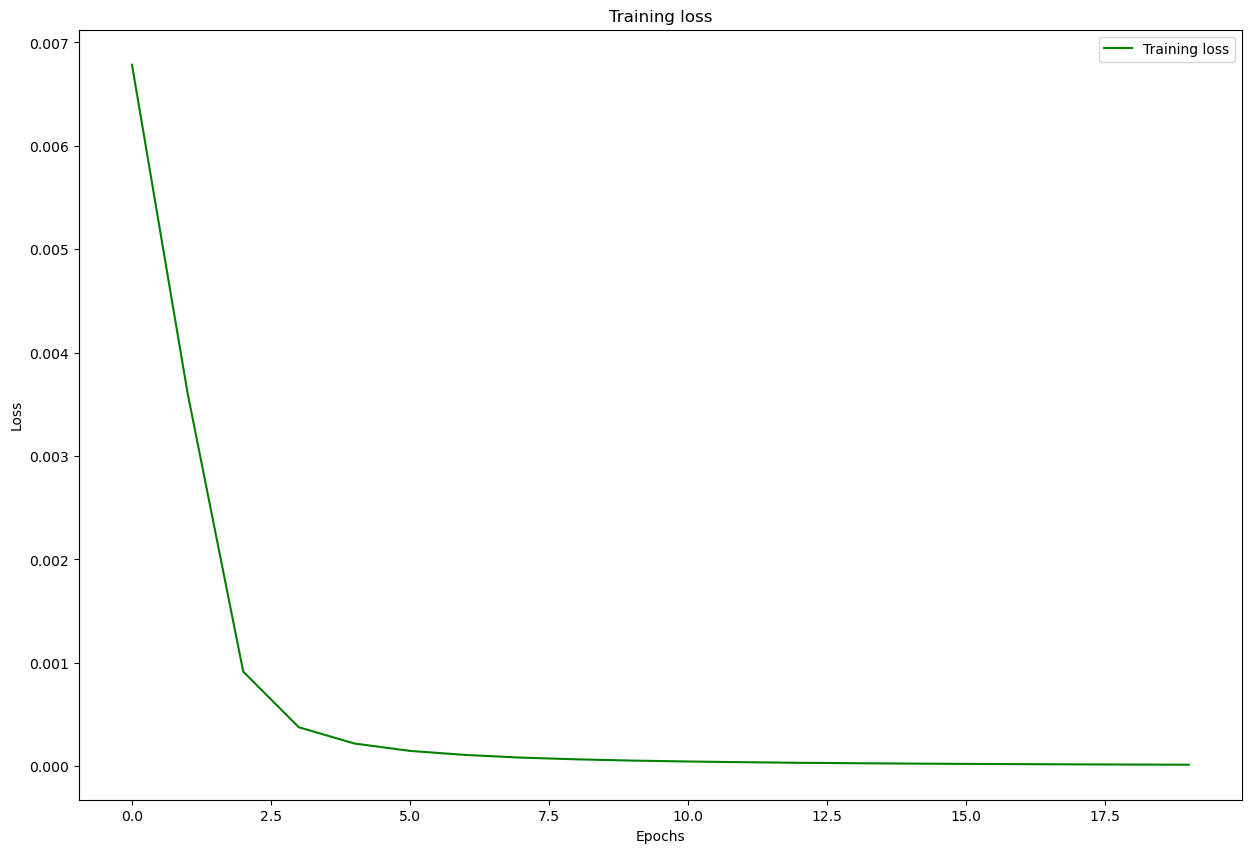

In [80]:
N = 20
plt.figure(figsize=(15,10))
plt.plot([np.mean(losses_simple[i*100:(i+1)*100]) for i in range(N)], 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [82]:
def evaluate_SimpleRNNmodel(model, history_id, path_id, initial_wealth, fee_tier):
    tau = model.tau
    wealth = initial_wealth # not relevent since we are optimizing the IL+fees (a ratio)

    history = data[history_id]["history"]

    # Prepare context input (reshape price_path0 to match RNN input)
    input = torch.tensor(history, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)

    # Create the liquidity pool and bins
    pool = LiquidityPool(history[-1], fee_tier)
    bins = generate_buckets(tau, history[-1])
    pool.add_allocation(wealth, np.ones_like(bins), bins)

    # Get the weights from the model
    weights = model(input)

    ini_token0, ini_token1 = initial_comp(pool, wealth, weights , bins)

    price_path = data[history_id]["scenarios"][path_id]
    idx = 0
    allocation_count = 0
    while idx < len(price_path):

        weights = model(torch.tensor(history, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device))
        pool = LiquidityPool(price_path[idx], fee_tier)

        # Add allocation to the liquidity pool
        bins = generate_buckets(tau, price_path[idx])
        pool.add_allocation(0.99, np.ones(len(bins)), bins)

        while idx < len(price_path) and price_path[idx] <= bins[-1] and price_path[idx] >= bins[0] :
            history = np.roll(history, -1)
            history[-1] = price_path[idx]
            pool.swap_price(price_path[idx])
            idx += 1

        if idx < len(price_path):
            history = np.roll(history, -1)
            history[-1] = price_path[idx]
            pool.swap_price(price_path[idx])
            
        non_weighted_wealth = evaluate(pool, 1, bins)

        # Convert reward to tensor and calculate relative performance
        non_weighted_wealth = wealth*torch.tensor(non_weighted_wealth, dtype=torch.float32)
        wealth = torch.dot(weights, non_weighted_wealth)
        allocation_count += 1

    hold_val = ini_token0 * pool.current_price + ini_token1

    return ((wealth-hold_val)/hold_val).item(), allocation_count, wealth.item(), hold_val.item()

### Testing

In [91]:
initial_wealth = 100000  # Initial wealth
fee_tier = 0.05  # Fee tier
SimpleRNNmodel_returns = [evaluate_SimpleRNNmodel(SimpleRNNmodel, id, 1, initial_wealth, fee_tier)[0] for id in range(100,300)] + [evaluate_SimpleRNNmodel(SimpleRNNmodel, id, 2, initial_wealth, fee_tier)[0] for id in range(100,300)]
SimpleRNNfinal_return = np.mean(SimpleRNNmodel_returns)
print(f"Final expected return : {round(100*SimpleRNNfinal_return,4)}%")

Final expected return : 0.0036%


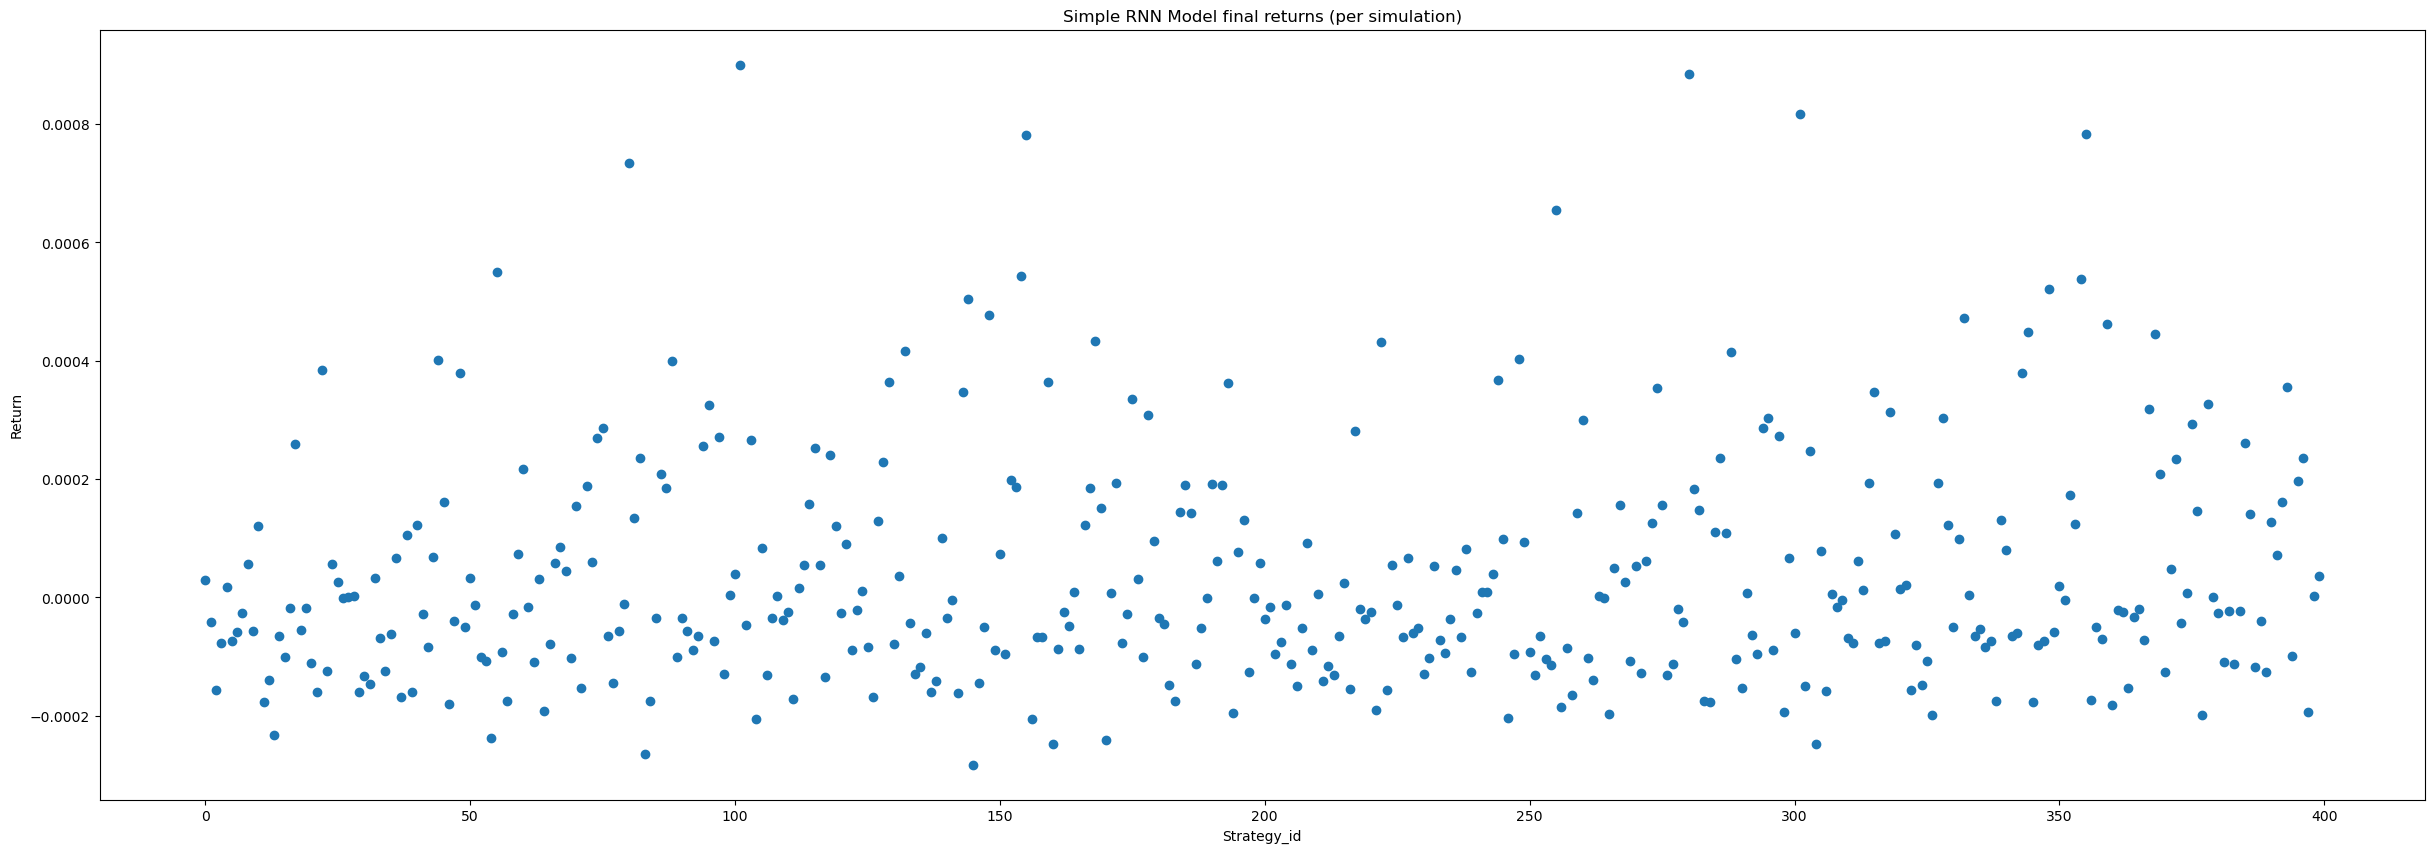

In [92]:
plt.figure(figsize=(30,10))
indexes = list(range(len(SimpleRNNmodel_returns)))
plt.scatter(indexes, SimpleRNNmodel_returns)
plt.title("Simple RNN Model final returns (per simulation)")
plt.xlabel("Strategy_id")
plt.ylabel("Return")
plt.show()

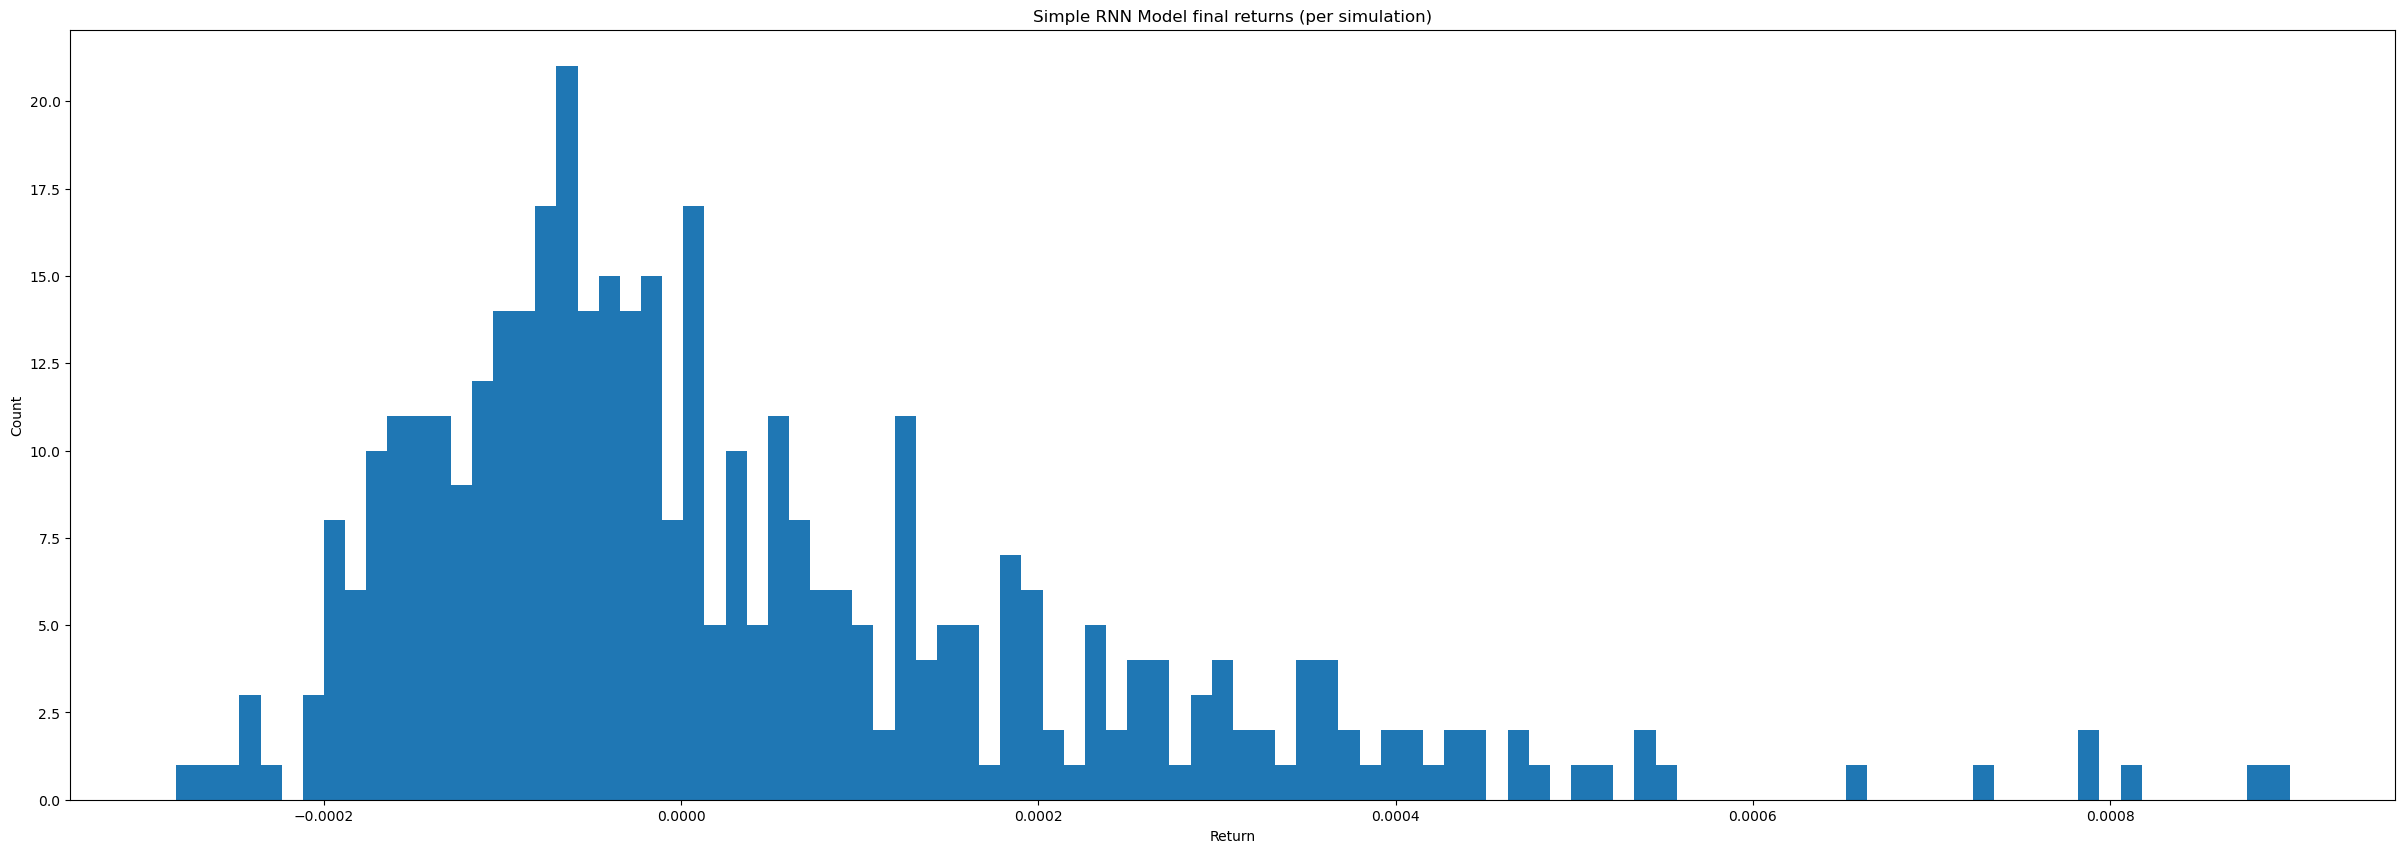

In [93]:
plt.figure(figsize=(30,10))
plt.hist(SimpleRNNmodel_returns, bins=100)
plt.title("Simple RNN Model final returns (per simulation)")
plt.xlabel("Return")
plt.ylabel("Count")
plt.show()

## Robust RNN with reallocations

In [204]:
class RobustRNNAllocationNetwork(nn.Module):
    def __init__(self, first_alloc_ts=600, tau= 10, input_size=1, hidden_size=16, num_layers=5):
        super(RobustRNNAllocationNetwork, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.tau = tau
        self.first_alloc_ts = first_alloc_ts

        # RNN layer
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        
        # Output layer applied at each time step
        self.fc = nn.Linear(hidden_size, 2*tau+2)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, 1, self.hidden_size).to(x.device)
        out, hn = self.rnn(x, h0)
        out = self.fc(out)  # Get output for each timestep
        out = self.softmax(out)
        # intialize the moment of the first allocation ad the condition's params
        start_price = x[:, self.first_alloc_ts, 0]
        phi = 1.0001**10
        central_value = int(np.log(start_price) / np.log(phi))
        min_price, max_price = phi ** (central_value - self.tau), phi ** (central_value + self.tau+1)

        # Condition-based output selection
        selected_outputs = [out[:, self.first_alloc_ts, :].squeeze()]
        for i in range(self.first_alloc_ts+1,x.size(1)):  # Iterate over sequence length
            # Assuming x contains the prices and we want to check when the price reaches the condition value
            if x[:, i, 0] < min_price or x[:, i, 0] > max_price :  # Check if reallocation is triggered 
                start_price = x[:, i, 0]
                phi = 1.0001**10
                central_value = int(np.log(start_price) / np.log(phi))
                min_price, max_price = phi ** (central_value - self.tau), phi ** (central_value + self.tau+1)
                selected_outputs.append(out[:, i, :].squeeze())  # Store the output at this timestep

        return selected_outputs

def utility(a, r):
    return (1-torch.exp(-a*r))/a if a !=0 else r

def generate_buckets(num_buckets, start_price, phi = 1.0001**10):
    central_value = int(np.log(start_price) / np.log(phi))
    return [phi ** (central_value + i) for i in range(-num_buckets, num_buckets + 2)]

def evaluate(pool, wealth , bins):
    val = []
    for i in range(len(bins)-1):
        token0, token1 = pool.get_position_comp(bins[i], bins[i+1])
        token0 += pool.get_position_fees(bins[i], bins[i+1], 0)
        token1 += pool.get_position_fees(bins[i], bins[i+1], 1)
        val.append(token1 + token0 * pool.current_price)
    val.append(wealth)
    return val

def initial_comp(pool, wealth , weights, bins):
    comps0, comps1 = [], []

    for i in range(len(bins)-1):
        token0, token1 = pool.get_position_comp(bins[i], bins[i+1])
        comps0.append(token0)
        comps1.append(token1)

    comps0.append(0) # 0 cash in tokens0
    comps1.append(wealth) # a certain amount to be defined by the weight

    comps0, comps1 = torch.tensor(comps0, dtype=torch.float32), torch.tensor(comps1, dtype=torch.float32)

    return torch.dot(comps0, weights), torch.dot(comps1, weights)

def RobustRNN_train_model(model, a, fee_tier, num_epochs=100, num_paths=100, lr=0.001, device='cpu'):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []
    for epoch in range(num_epochs):
        for path_id in range(num_paths):
            optimizer.zero_grad()
            wealth = 1000 # not relevent since we are optimizing the IL+fees (a ratio)
            # Randomly generate initial price and wealth
            price_path = single_price_paths[path_id]

            # Prepare context input (reshape price_path0 to match RNN input)
            price_path_history = torch.tensor(price_path, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
            # Shape of price_path_history: (batch_size=1, seq_length=price_path_length, input_size=1)
        
            # Create the liquidity pool and bins
            pool = LiquidityPool(price_path[model.first_alloc_ts], fee_tier, gov=0)
            bins = generate_buckets(model.tau, price_path[model.first_alloc_ts])
            pool.add_allocation(wealth, np.ones_like(bins), bins)
            
            idx = model.first_alloc_ts
            allocation_count = 0

            # Get the weights from the model
            reallocations_weights = model(price_path_history)
            
            # Compute initial token composition
            weights = reallocations_weights[allocation_count]

            ini_token0, ini_token1 = initial_comp(pool, wealth, weights , bins)

            while idx < len(price_path):

                weights = reallocations_weights[allocation_count]
                pool = LiquidityPool(price_path[idx], fee_tier, gov=0)

                # Add allocation to the liquidity pool
                bins = generate_buckets(model.tau, price_path[idx])
                pool.add_allocation(1, np.ones(len(bins)), bins) # mint and burn fees applied

                while idx < len(price_path) and price_path[idx] <= bins[-1] and price_path[idx] >= bins[0] :
                    pool.swap_price(price_path[idx])
                    idx += 1

                if idx < len(price_path):
                    pool.swap_price(price_path[idx])
                    
                non_weighted_wealth = evaluate(pool, 1, bins)

                # Convert reward to tensor and calculate relative performance
                non_weighted_wealth = wealth*torch.tensor(non_weighted_wealth, dtype=torch.float32)
                wealth = torch.dot(weights, non_weighted_wealth)
                allocation_count += 1

            hold_val = ini_token0 * pool.current_price + ini_token1

            total_reward  = (wealth-hold_val)/hold_val
            vol = price_path.std()
            # Use the total reward as the objective (loss is negative reward)
            loss = -utility(a,total_reward/vol)
            losses.append(loss.item())
            
            # Backpropagation
            loss.backward()
            optimizer.step()
            
        writer.add_scalar("Loss/train", loss, epoch)
            # Print progress every few epochs
            #if epoch % 10 == 0:
            #    print(f"Epoch {epoch}, Loss: {loss.item()}, Reward: {total_reward.item()}, Allocations:{allocation_count}, wealth:{wealth}, hold:{hold_val}")
        if epoch % 1 == 0:
            print(f"Epoch {epoch}, Loss: {np.mean(losses[epoch*num_paths:(epoch+1)*num_paths])}")
    return losses

In [8]:
tau = 20
hidden_size = 16
first_alloc_ts = 200
RobustRNNmodel = RobustRNNAllocationNetwork(first_alloc_ts=first_alloc_ts, tau=tau, input_size=1, hidden_size=hidden_size, num_layers=2)
fee_tier = 0.05
a = 0
# Train the model
losses_robu = RobustRNN_train_model(RobustRNNmodel, a, fee_tier, num_epochs=20, num_paths=150, lr=0.001)

Epoch 0, Loss: 9.64605013897805e-05
Epoch 1, Loss: 4.9731206764818126e-05
Epoch 2, Loss: 2.0436665438410272e-05
Epoch 3, Loss: 1.1709755362119268e-05
Epoch 4, Loss: 7.506099422466643e-06
Epoch 5, Loss: 3.8091098467448367e-06
Epoch 6, Loss: 2.2326112416948262e-06
Epoch 7, Loss: 1.0611490759041923e-06
Epoch 8, Loss: 7.53262822274318e-07
Epoch 9, Loss: 4.554698745214599e-07
Epoch 10, Loss: 4.4887384055947164e-07
Epoch 11, Loss: 3.116056580839318e-07
Epoch 12, Loss: 3.200511423713988e-07
Epoch 13, Loss: 2.7914857342252e-07
Epoch 14, Loss: 1.9987011574684742e-07
Epoch 15, Loss: 1.6200607024193423e-07
Epoch 16, Loss: 1.6349845593917796e-07
Epoch 17, Loss: 1.267383364197035e-07
Epoch 18, Loss: 1.2535397507192531e-07
Epoch 19, Loss: 1.0397312843357654e-07


In [ ]:
torch.save(RobustRNNmodel, 'rnn_a0')

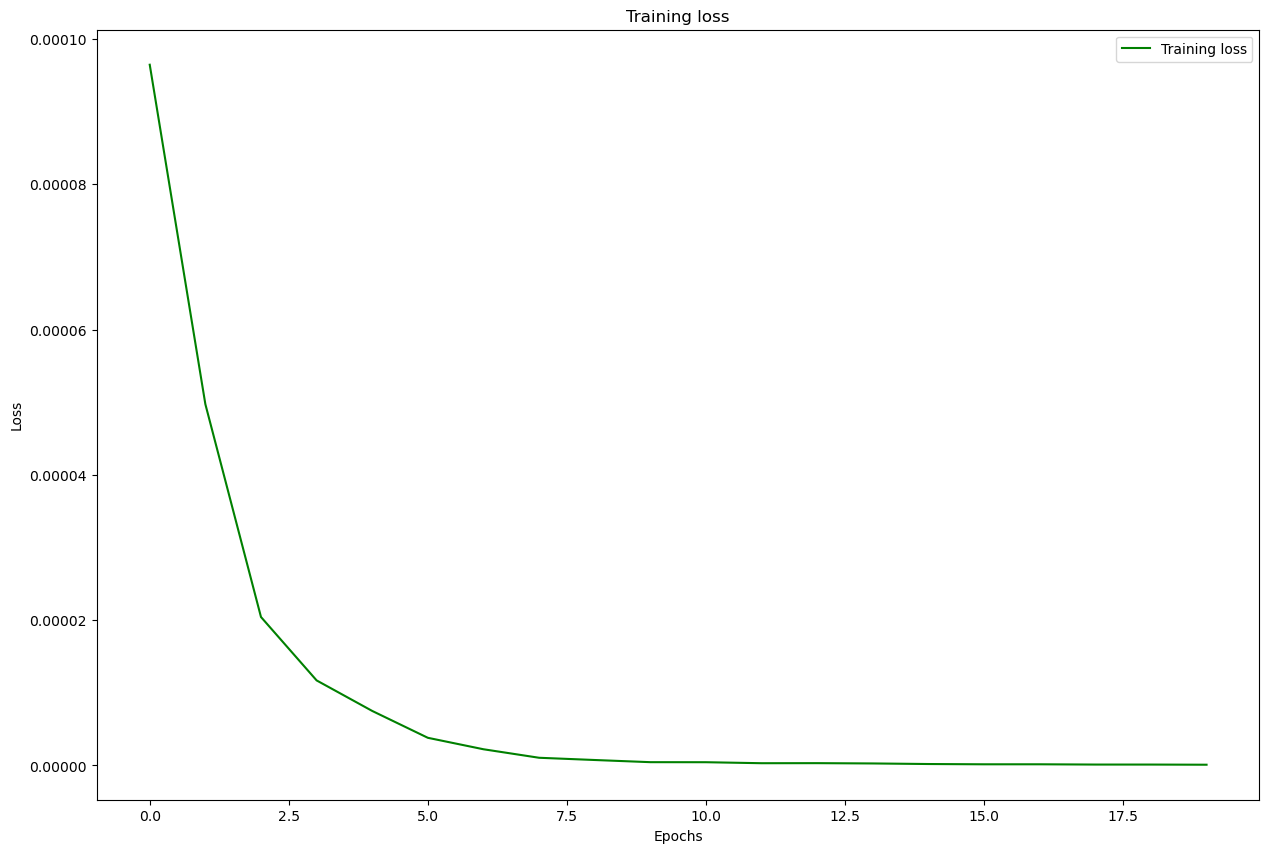

In [9]:
epochs = 20
n_paths = 150
plt.figure(figsize=(15,10))
plt.plot([np.mean(losses_robu[i*n_paths:(i+1)*n_paths]) for i in range(epochs)], 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Testing

In [34]:
def evaluate_RobustRNNmodel(model, path_id, initial_wealth, fee_tier):
    tau = model.tau
    wealth = initial_wealth # not relevent since we are optimizing the IL+fees (a ratio)
    # Randomly generate initial price and wealth
    price_path = single_price_paths[path_id]

    # Prepare context input (reshape price_path0 to match RNN input)
    price_path_history = torch.tensor(price_path, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
    # Shape of price_path_history: (batch_size=1, seq_length=price_path_length, input_size=1)

    # Create the liquidity pool and bins
    pool = LiquidityPool(price_path[600], fee_tier, gov=0.1)
    bins = generate_buckets(tau, price_path[600])
    pool.add_allocation(wealth, np.ones_like(bins), bins)
    
    idx = model.first_alloc_ts
    allocation_count = 0

    # Get the weights from the model
    reallocations_weights = model(price_path_history)
    
    # Compute initial token composition
    weights = reallocations_weights[allocation_count]

    ini_token0, ini_token1 = initial_comp(pool, wealth, weights , bins)

    while idx < len(price_path):

        weights = reallocations_weights[allocation_count]
        pool = LiquidityPool(price_path[idx], fee_tier, gov=0.1)

        # Add allocation to the liquidity pool
        bins = generate_buckets(tau, price_path[idx])
        pool.add_allocation(1, np.ones(len(bins)), bins)

        while idx < len(price_path) and price_path[idx] <= bins[-1] and price_path[idx] >= bins[0] :
            pool.swap_price(price_path[idx])
            idx += 1

        if idx < len(price_path):
            pool.swap_price(price_path[idx])
            
        non_weighted_wealth = evaluate(pool, 1, bins)

        # Convert reward to tensor and calculate relative performance
        non_weighted_wealth = wealth*torch.tensor(non_weighted_wealth, dtype=torch.float32)
        wealth = torch.dot(weights, non_weighted_wealth)

        allocation_count += 1

    hold_val = ini_token0 * pool.current_price + ini_token1

    return ((wealth-hold_val)/hold_val).item(), allocation_count, wealth.item(), hold_val.item()

In [236]:
def evaluate_Constantmodel(model, path_id, initial_wealth, fee_tier):
    tau = model.tau
    wealth = initial_wealth # not relevent since we are optimizing the IL+fees (a ratio)
    # Randomly generate initial price and wealth
    price_path = single_price_paths[path_id]

    # Prepare context input (reshape price_path0 to match RNN input)
    price_path_history = torch.tensor(price_path, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
    # Shape of price_path_history: (batch_size=1, seq_length=price_path_length, input_size=1)

    # Create the liquidity pool and bins
    pool = LiquidityPool(price_path[200], fee_tier)
    bins = generate_buckets(tau, price_path[200])
    pool.add_allocation(wealth, np.ones_like(bins), bins)
    
    idx = model.first_alloc_ts
    allocation_count = 0
    
    # Compute initial token composition
    weights = torch.ones(2*tau+2)/(2*tau+2)

    ini_token0, ini_token1 = initial_comp(pool, wealth, weights , bins)

    while idx < len(price_path):

        pool = LiquidityPool(price_path[idx], fee_tier)

        # Add allocation to the liquidity pool
        bins = generate_buckets(tau, price_path[idx])
        pool.add_allocation(1, np.ones(len(bins)), bins)

        while idx < len(price_path) and price_path[idx] <= bins[-1] and price_path[idx] >= bins[0] :
            pool.swap_price(price_path[idx])
            idx += 1

        if idx < len(price_path):
            pool.swap_price(price_path[idx])
            
        non_weighted_wealth = evaluate(pool, 1, bins)

        # Convert reward to tensor and calculate relative performance
        non_weighted_wealth = wealth * torch.tensor(non_weighted_wealth, dtype=torch.float32)
        wealth = torch.dot(weights, non_weighted_wealth)
        allocation_count += 1

    hold_val = ini_token0 * pool.current_price + ini_token1

    return ((wealth-hold_val)/hold_val).item(), allocation_count, wealth.item(), hold_val.item()

Final expected return : -0.67%


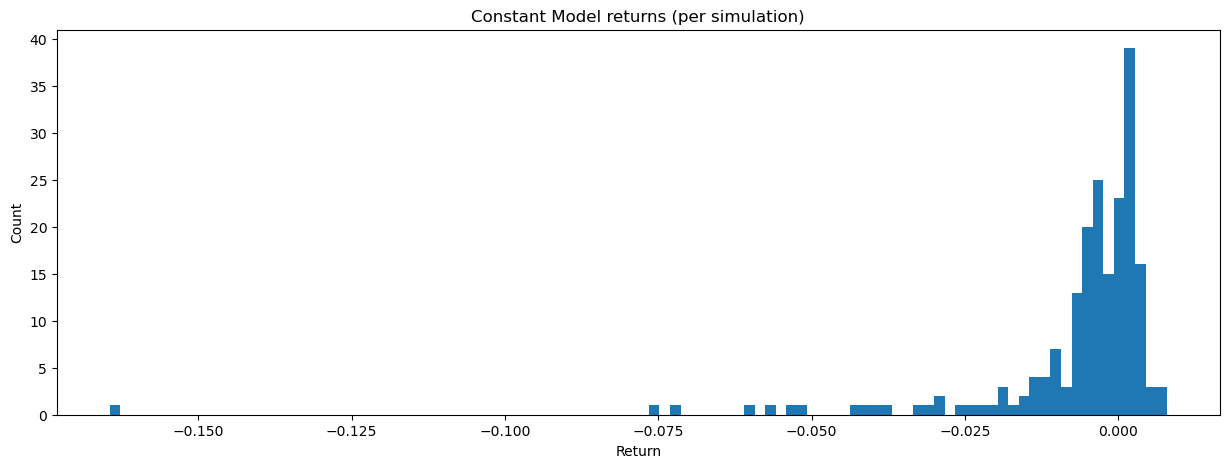

In [246]:
tau = 20
hidden_size = 16
first_alloc_ts = 200
model = RobustRNNAllocationNetwork(first_alloc_ts=first_alloc_ts, tau=tau, input_size=1, hidden_size=hidden_size, num_layers=2) #empty model just to get the relevant parameters
initial_wealth = 100000  # Initial wealth
fee_tier = 0.05  # Fee tier
Constantmodel_returns_20 = [evaluate_Constantmodel(model, id, initial_wealth, fee_tier)[0] for id in range(200,400)]
constant_final_return_20 = np.mean(Constantmodel_returns_20)
print(f"Final expected return : {round(100*constant_final_return_20,2)}%")
plt.figure(figsize=(15,5))
plt.hist(Constantmodel_returns_20, bins=100)
plt.title("Constant Model returns (per simulation)")
plt.xlabel("Return")
plt.ylabel("Count")
plt.show()

In [248]:
# Sample list of returns
returns = Constantmodel_returns_20

# Convert the list to a numpy array for calculations
returns_array = np.array(returns)

# Mean return
mean_return = np.mean(returns_array)

# VaR at 95% confidence level
var_95 = np.percentile(returns_array, 5)

# CVaR (Expected Shortfall) at 95% confidence level
cvar_95 = np.mean(returns_array[returns_array <= var_95])

# Quartiles (Q1, Q2 (median), Q3)
q1 = np.percentile(returns_array, 25)
median = np.percentile(returns_array, 50)
q3 = np.percentile(returns_array, 75)

# Maximum and Minimum returns
max_return = np.max(returns_array)
min_return = np.min(returns_array)

# Create a dictionary to store the results
results = {
    'Model': 'Constant_20',
    'Mean Return': mean_return,
    'VaR (95%)': var_95,
    'CVaR (95%)': cvar_95,
    'Q1 (25th percentile)': q1,
    'Median (50th percentile)': median,
    'Q3 (75th percentile)': q3,
    'Max Return': max_return,
    'Min Return': min_return
}

# Convert the results to a DataFrame for a cleaner display
results_df = pd.DataFrame(results, index=[0])
results_df.head()


,Model,Mean Return,VaR (95%),CVaR (95%),Q1 (25th percentile),Median (50th percentile),Q3 (75th percentile),Max Return,Min Return
0,Constant_20,-0.006678,-0.037632,-0.065962,-0.00694,-0.002541,0.001364,0.007901,-0.164441


Final expected return : -0.2%


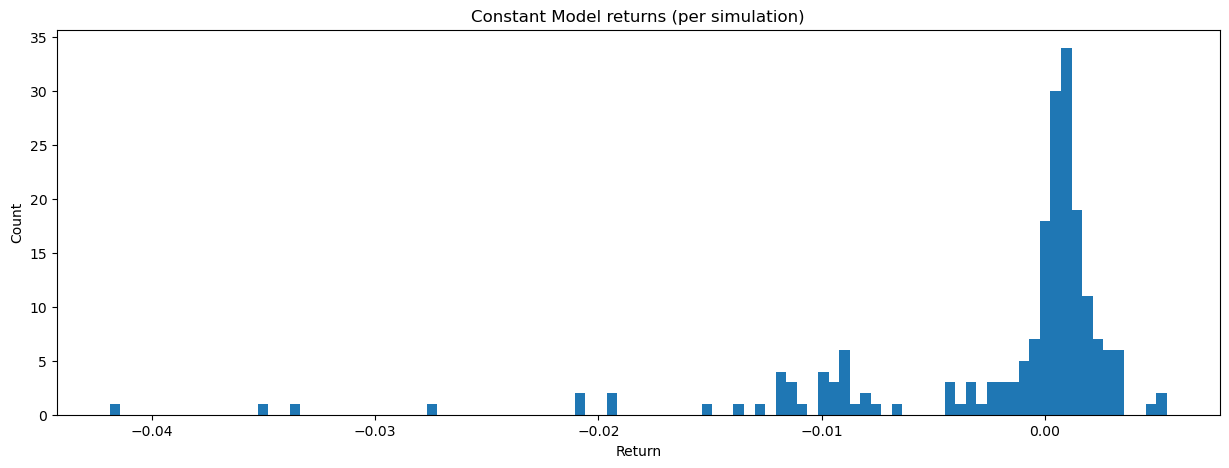

In [245]:
tau = 50
hidden_size = 16
first_alloc_ts = 200
model = RobustRNNAllocationNetwork(first_alloc_ts=first_alloc_ts, tau=tau, input_size=1, hidden_size=hidden_size, num_layers=2) #empty model just to get the relevant parameters
initial_wealth = 100000  # Initial wealth
fee_tier = 0.05  # Fee tier
Constantmodel_returns_50 = [evaluate_Constantmodel(model, id, initial_wealth, fee_tier)[0] for id in range(200,400)]
constant_final_return_50 = np.mean(Constantmodel_returns_50)
print(f"Final expected return : {round(100*constant_final_return_50,2)}%")
plt.figure(figsize=(15,5))
plt.hist(Constantmodel_returns_50, bins=100)
plt.title("Constant Model returns (per simulation)")
plt.xlabel("Return")
plt.ylabel("Count")
plt.show()

In [249]:
returns = Constantmodel_returns_50

# Convert the list to a numpy array for calculations
returns_array = np.array(returns)

# Mean return
mean_return = np.mean(returns_array)

# VaR at 95% confidence level
var_95 = np.percentile(returns_array, 5)

# CVaR (Expected Shortfall) at 95% confidence level
cvar_95 = np.mean(returns_array[returns_array <= var_95])

# Quartiles (Q1, Q2 (median), Q3)
q1 = np.percentile(returns_array, 25)
median = np.percentile(returns_array, 50)
q3 = np.percentile(returns_array, 75)

# Maximum and Minimum returns
max_return = np.max(returns_array)
min_return = np.min(returns_array)

# Create a dictionary to store the results
results = {
    'Model': 'Constant_50',
    'Mean Return': mean_return,
    'VaR (95%)': var_95,
    'CVaR (95%)': cvar_95,
    'Q1 (25th percentile)': q1,
    'Median (50th percentile)': median,
    'Q3 (75th percentile)': q3,
    'Max Return': max_return,
    'Min Return': min_return
}

# Convert the results to a DataFrame for a cleaner display
results_df.loc[len(results_df)] = results
results_df.head()

,Model,Mean Return,VaR (95%),CVaR (95%),Q1 (25th percentile),Median (50th percentile),Q3 (75th percentile),Max Return,Min Return
0,Constant_20,-0.006678,-0.037632,-0.065962,-0.006940,-0.002541,0.001364,0.007901,-0.164441
1,Constant_50,-0.002026,-0.012667,-0.024647,-0.001902,0.000508,0.001211,0.005447,-0.041874


Final expected return : -0.0489%


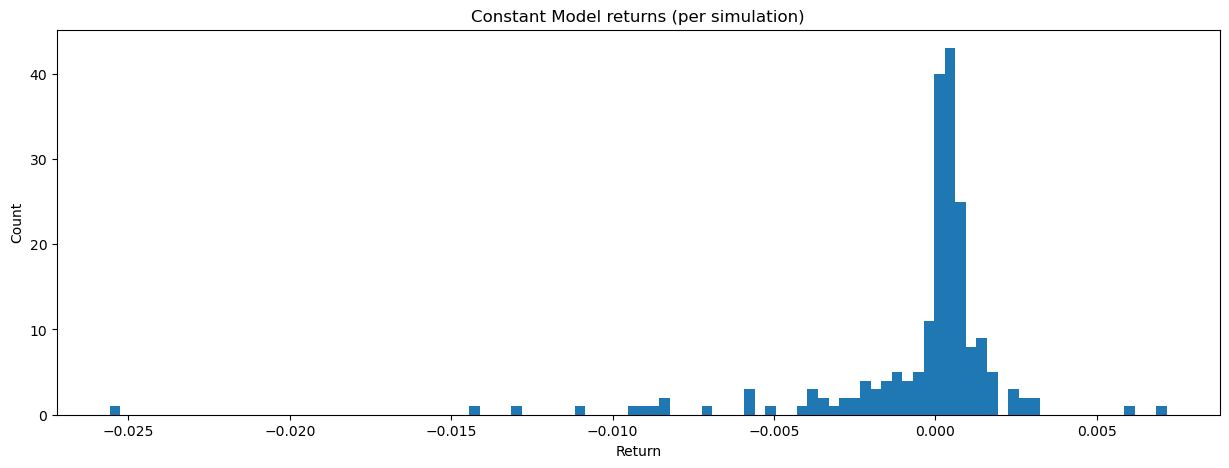

In [244]:
tau = 100
hidden_size = 16
first_alloc_ts = 200
model = RobustRNNAllocationNetwork(first_alloc_ts=first_alloc_ts, tau=tau, input_size=1, hidden_size=hidden_size, num_layers=2) #empty model just to get the relevant parameters
initial_wealth = 100000  # Initial wealth
fee_tier = 0.05  # Fee tier
Constantmodel_returns_100 = [evaluate_Constantmodel(model, id, initial_wealth, fee_tier)[0] for id in range(200,400)]
constant_final_return_100 = np.mean(Constantmodel_returns_100)
print(f"Final expected return : {round(100*constant_final_return_100,4)}%")
plt.figure(figsize=(15,5))
plt.hist(Constantmodel_returns_100, bins=100)
plt.title("Constant Model returns (per simulation)")
plt.xlabel("Return")
plt.ylabel("Count")
plt.show()

In [250]:
returns = Constantmodel_returns_100

# Convert the list to a numpy array for calculations
returns_array = np.array(returns)

# Mean return
mean_return = np.mean(returns_array)

# VaR at 95% confidence level
var_95 = np.percentile(returns_array, 5)

# CVaR (Expected Shortfall) at 95% confidence level
cvar_95 = np.mean(returns_array[returns_array <= var_95])

# Quartiles (Q1, Q2 (median), Q3)
q1 = np.percentile(returns_array, 25)
median = np.percentile(returns_array, 50)
q3 = np.percentile(returns_array, 75)

# Maximum and Minimum returns
max_return = np.max(returns_array)
min_return = np.min(returns_array)

# Create a dictionary to store the results
results = {
    'Model': 'Constant_100',
    'Mean Return': mean_return,
    'VaR (95%)': var_95,
    'CVaR (95%)': cvar_95,
    'Q1 (25th percentile)': q1,
    'Median (50th percentile)': median,
    'Q3 (75th percentile)': q3,
    'Max Return': max_return,
    'Min Return': min_return
}

# Convert the results to a DataFrame for a cleaner display
results_df.loc[len(results_df)] = results
results_df.head()

,Model,Mean Return,VaR (95%),CVaR (95%),Q1 (25th percentile),Median (50th percentile),Q3 (75th percentile),Max Return,Min Return
0,Constant_20,-0.006678,-0.037632,-0.065962,-0.006940,-0.002541,0.001364,0.007901,-0.164441
1,Constant_50,-0.002026,-0.012667,-0.024647,-0.001902,0.000508,0.001211,0.005447,-0.041874
2,Constant_100,-0.000489,-0.005835,-0.011461,-0.000348,0.000286,0.000694,0.007170,-0.025577


In [14]:
initial_wealth = 100000  # Initial wealth
fee_tier = 0.05  # Fee tier
RobustRNNmodel_returns = [evaluate_RobustRNNmodel(RobustRNNmodel, id, initial_wealth, fee_tier)[0] for id in range(100,500)]
final_return = np.mean(RobustRNNmodel_returns)
print(f"Final expected return : {round(100*final_return,4)}%")

Final expected return : -0.0%


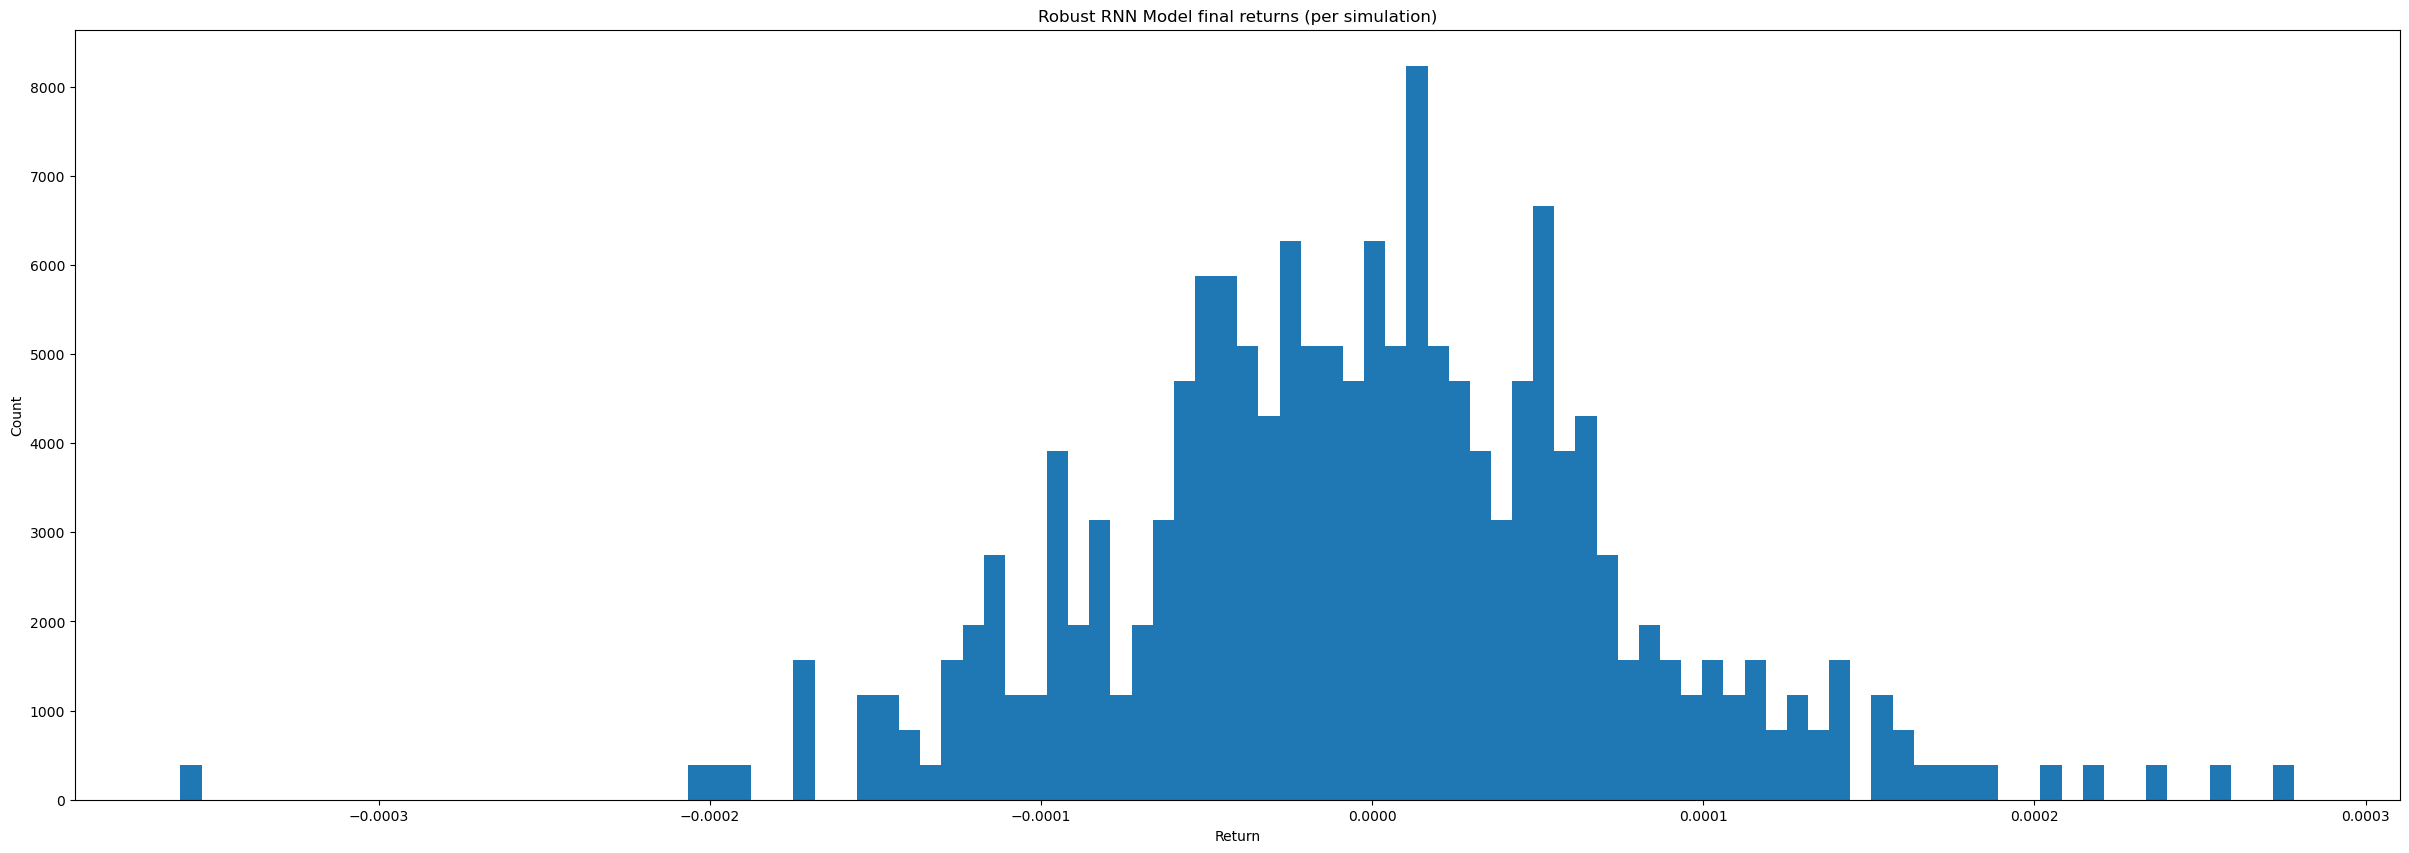

In [15]:
plt.figure(figsize=(30,10))
plt.hist(RobustRNNmodel_returns, density=True, bins=100)
plt.title("Robust RNN Model final returns (per simulation)")
plt.xlabel("Return")
plt.ylabel("Count")
plt.show()

In [ ]:
tau = 20
hidden_size = 16
first_alloc_ts = 200
RobustRNNmodel = RobustRNNAllocationNetwork(first_alloc_ts=first_alloc_ts, tau=tau, input_size=1, hidden_size=hidden_size, num_layers=2)
fee_tier = 0.05
a = 10
# Train the model
losses_robu = RobustRNN_train_model(RobustRNNmodel, a, fee_tier, num_epochs=20, num_paths=150, lr=0.001)

In [ ]:
initial_wealth = 100000  # Initial wealth
fee_tier = 0.05  # Fee tier
RobustRNNmodel_returns = [evaluate_RobustRNNmodel(RobustRNNmodel, id, initial_wealth, fee_tier)[0] for id in range(100,500)]
final_return = np.mean(RobustRNNmodel_returns)
print(f"Final expected return : {round(100*final_return,2)}%")

Final expected return : 8.42%


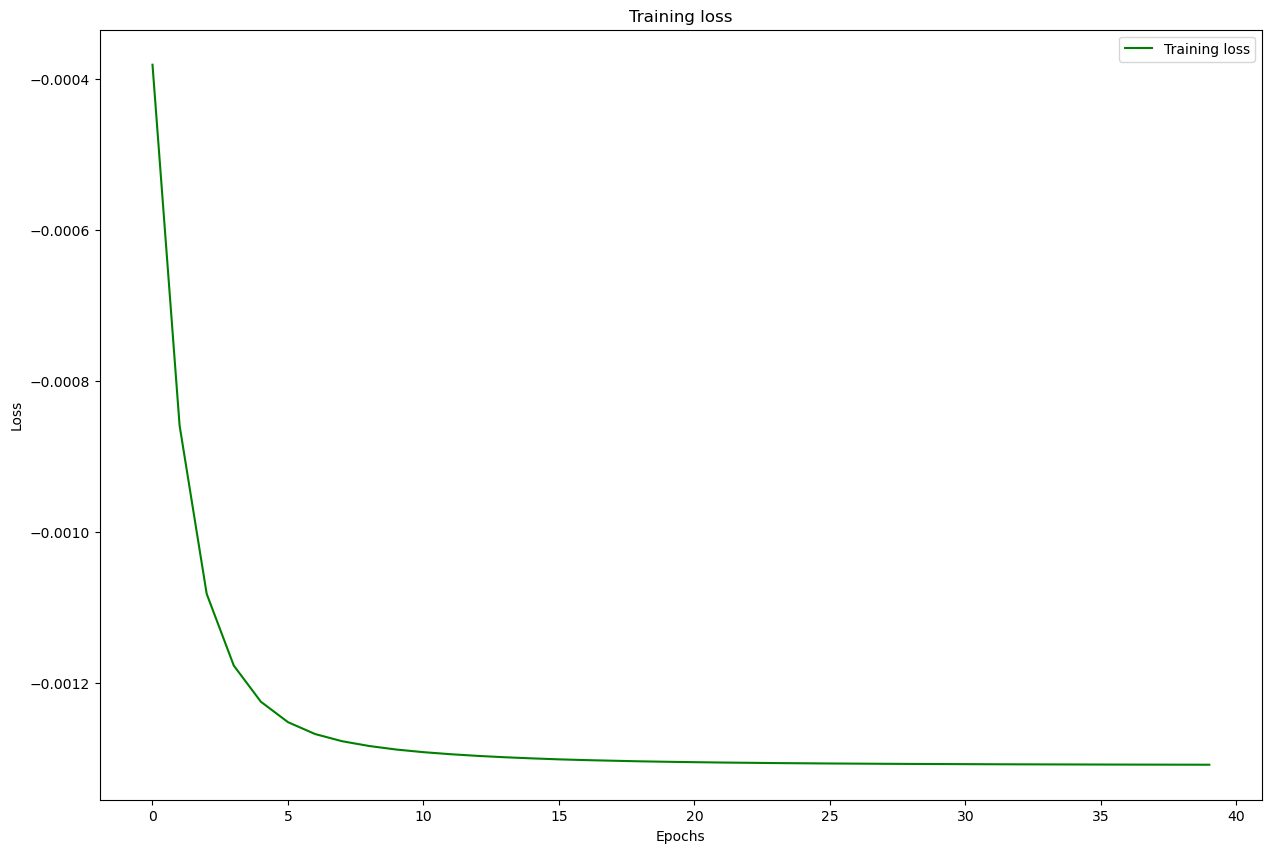

In [ ]:
epochs = 20
n_paths = 150
plt.figure(figsize=(15,10))
plt.plot([np.mean(losses_robu[i*n_paths:(i+1)*n_paths]) for i in range(epochs)], 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
torch.save(RobustRNNmodel,'rnn_a10')

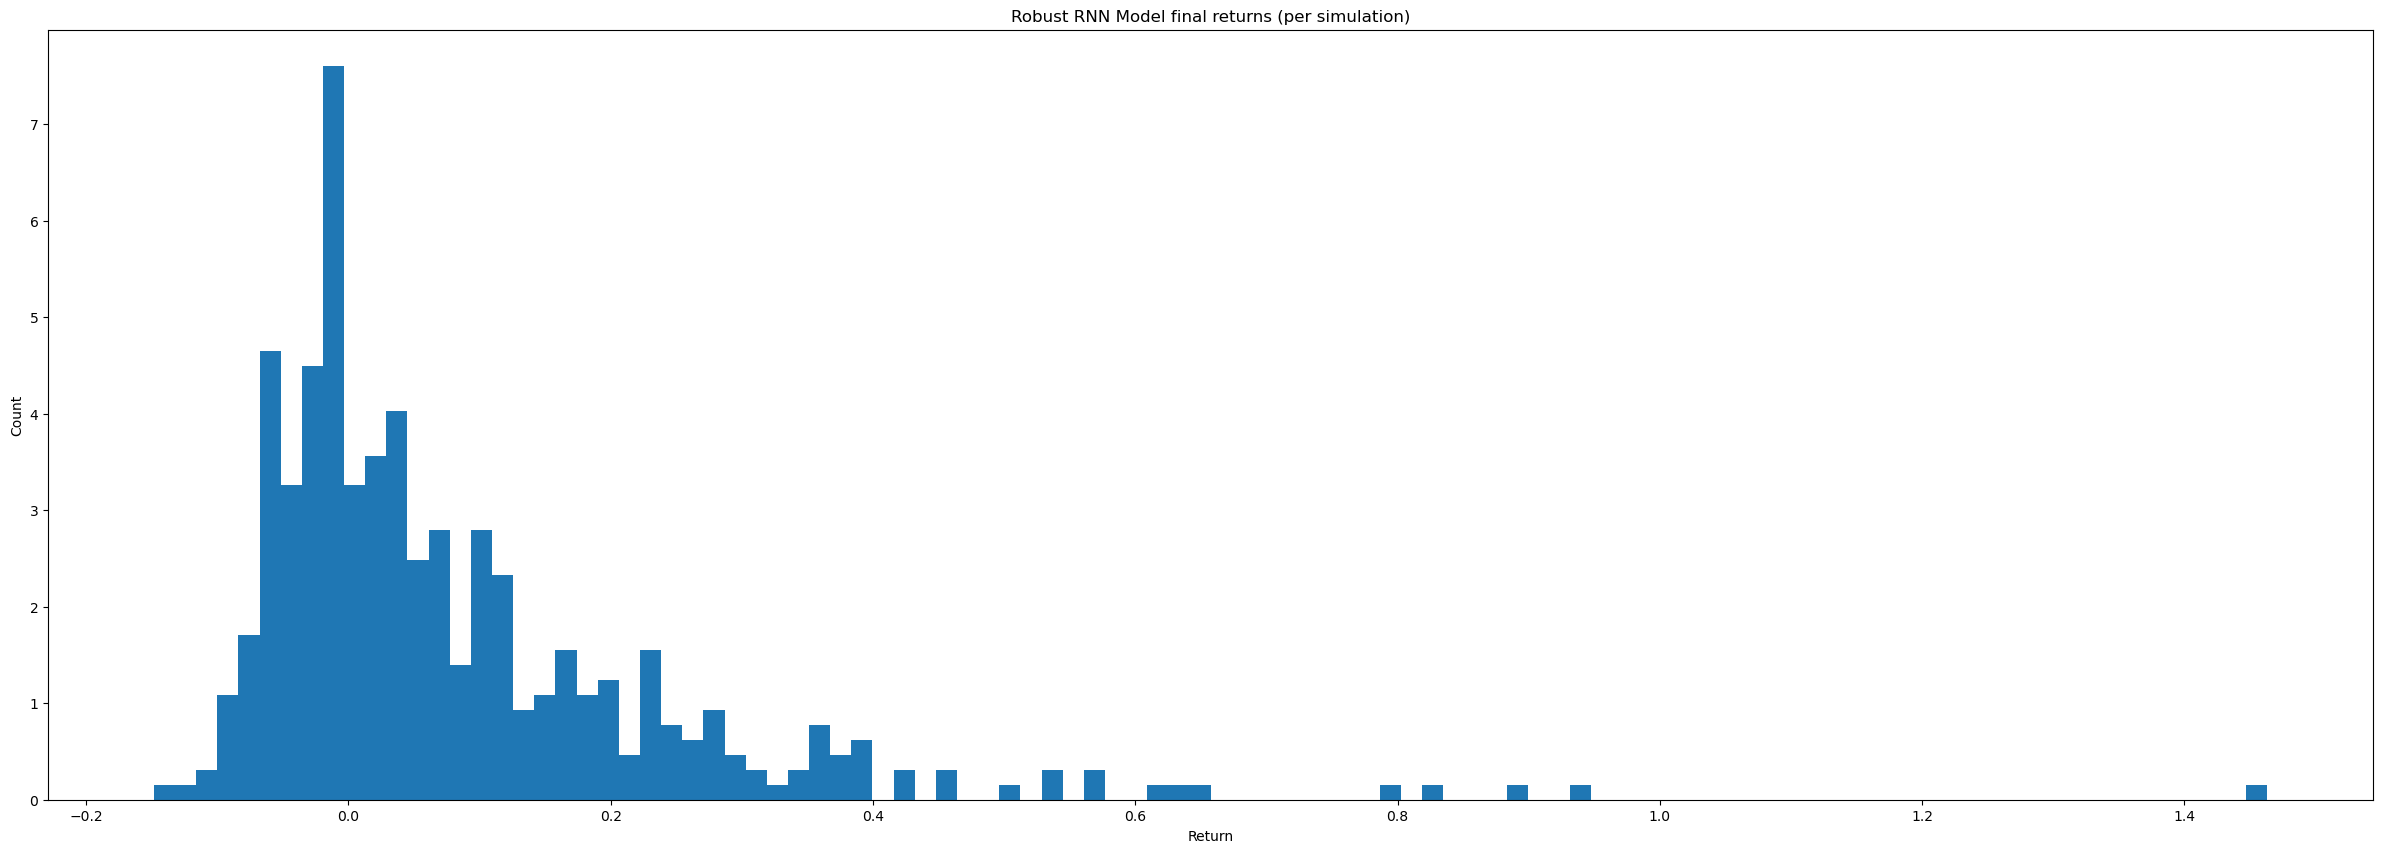

In [ ]:
plt.figure(figsize=(30,10))
plt.hist(RobustRNNmodel_returns, density=True, bins=100)
plt.title("Robust RNN Model final returns (per simulation)")
plt.xlabel("Return")
plt.ylabel("Count")
plt.show()

### LSTM Modem with reallocations

In [205]:

class RobustLSTMAllocationNetwork(nn.Module):
    def __init__(self, first_alloc_ts=600, tau= 10, input_size=1, hidden_size=16, num_layers=5):
        super(RobustLSTMAllocationNetwork, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.tau = tau
        self.first_alloc_ts = first_alloc_ts

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        
        # Output layer applied at each time step
        self.fc = nn.Linear(hidden_size, 2*tau+2)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, 1, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, 1, self.hidden_size).to(x.device)
        out, (hn, cn) = self.lstm(x, (h0,c0))
        out = self.fc(out)  # Get output for each timestep
        out = self.softmax(out)
        # intialize the moment of the first allocation ad the condition's params
        start_price = x[:, self.first_alloc_ts, 0]
        phi = 1.0001**10
        central_value = int(np.log(start_price) / np.log(phi))
        min_price, max_price = phi ** (central_value - self.tau), phi ** (central_value + self.tau+1)

        # Condition-based output selection
        selected_outputs = [out[:, self.first_alloc_ts, :].squeeze()]
        for i in range(self.first_alloc_ts+1,x.size(1)):  # Iterate over sequence length
            # Assuming x contains the prices and we want to check when the price reaches the condition value
            if x[:, i, 0] < min_price or x[:, i, 0] > max_price :  # Check if reallocation is triggered 
                start_price = x[:, i, 0]
                phi = 1.0001**10
                central_value = int(np.log(start_price) / np.log(phi))
                min_price, max_price = phi ** (central_value - self.tau), phi ** (central_value + self.tau+1)
                selected_outputs.append(out[:, i, :].squeeze())  # Store the output at this timestep

        return selected_outputs

def utility(a, r):
    return (1-torch.exp(-a*r))/a if a !=0 else r

def generate_buckets(num_buckets, start_price, phi = 1.0001**10):
    central_value = int(np.log(start_price) / np.log(phi))
    return [phi ** (central_value + i) for i in range(-num_buckets, num_buckets + 2)]

def evaluate(pool, wealth , bins):
    val = []
    for i in range(len(bins)-1):
        token0, token1 = pool.get_position_comp(bins[i], bins[i+1])
        token0 += pool.get_position_fees(bins[i], bins[i+1], 0)
        token1 += pool.get_position_fees(bins[i], bins[i+1], 1)
        val.append(token1 + token0 * pool.current_price)
    val.append(wealth)
    return val

def initial_comp(pool, wealth , weights, bins):
    comps0, comps1 = [], []

    for i in range(len(bins)-1):
        token0, token1 = pool.get_position_comp(bins[i], bins[i+1])
        comps0.append(token0)
        comps1.append(token1)

    comps0.append(0) # 0 cash in tokens0
    comps1.append(wealth) # a certain amount to be defined by the weight

    comps0, comps1 = torch.tensor(comps0, dtype=torch.float32), torch.tensor(comps1, dtype=torch.float32)

    return torch.dot(comps0, weights), torch.dot(comps1, weights)

def RobustLSTM_train_model(model, a, fee_tier, num_epochs=100, num_paths=100, lr=0.001, device='cpu'):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []
    for epoch in range(num_epochs):
        for path_id in range(num_paths):
            optimizer.zero_grad()
            wealth = 1000 # not relevent since we are optimizing the IL+fees (a ratio)
            # Randomly generate initial price and wealth
            price_path = single_price_paths[path_id]

            # Prepare context input (reshape price_path0 to match RNN input)
            price_path_history = torch.tensor(price_path, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
            # Shape of price_path_history: (batch_size=1, seq_length=price_path_length, input_size=1)
        
            # Create the liquidity pool and bins
            pool = LiquidityPool(price_path[model.first_alloc_ts], fee_tier, gov=0)
            bins = generate_buckets(model.tau, price_path[model.first_alloc_ts])
            pool.add_allocation(wealth, np.ones_like(bins), bins)
            
            idx = model.first_alloc_ts
            allocation_count = 0

            # Get the weights from the model
            reallocations_weights = model(price_path_history)
            
            # Compute initial token composition
            weights = reallocations_weights[allocation_count]

            ini_token0, ini_token1 = initial_comp(pool, wealth, weights , bins)

            while idx < len(price_path):

                weights = reallocations_weights[allocation_count]
                pool = LiquidityPool(price_path[idx], fee_tier, gov=0)

                # Add allocation to the liquidity pool
                bins = generate_buckets(model.tau, price_path[idx])
                pool.add_allocation(1, np.ones(len(bins)), bins) # mint and burn fees applied

                while idx < len(price_path) and price_path[idx] <= bins[-1] and price_path[idx] >= bins[0] :
                    pool.swap_price(price_path[idx])
                    idx += 1

                if idx < len(price_path):
                    pool.swap_price(price_path[idx])
                    
                non_weighted_wealth = evaluate(pool, 1, bins)

                # Convert reward to tensor and calculate relative performance
                non_weighted_wealth = wealth*torch.tensor(non_weighted_wealth, dtype=torch.float32)
                wealth = torch.dot(weights, non_weighted_wealth)
                allocation_count += 1

            hold_val = ini_token0 * pool.current_price + ini_token1

            total_reward  = (wealth-hold_val)/hold_val
            vol = price_path.std()
            # Use the total reward as the objective (loss is negative reward)
            loss = -utility(a,total_reward/vol)
            losses.append(loss.item())
            
            # Backpropagation
            loss.backward()
            optimizer.step()
            
            
        writer.add_scalar("Loss/train", loss, epoch)
            # Print progress every few epochs
            #if epoch % 10 == 0:
            #    print(f"Epoch {epoch}, Loss: {loss.item()}, Reward: {total_reward.item()}, Allocations:{allocation_count}, wealth:{wealth}, hold:{hold_val}")
        if epoch % 1 == 0:
            print(f"Epoch {epoch}, Loss: {np.mean(losses[epoch*num_paths:(epoch+1)*num_paths])}")
    return losses

In [100]:
tau = 20
hidden_size = 16
first_alloc_ts = 200
RobustLSTMmodel = RobustLSTMAllocationNetwork(first_alloc_ts=first_alloc_ts, tau=tau, input_size=1, hidden_size=hidden_size, num_layers=2)
fee_tier = 0.05
a = 0
# Train the model
losses_robu_lstm = RobustLSTM_train_model(RobustLSTMmodel, a, fee_tier, num_epochs=20, num_paths=150, lr=0.001)

Epoch 0, Loss: -0.0006519085762526326
Epoch 1, Loss: -0.0014176455038932545
Epoch 2, Loss: -0.001779793754324525
Epoch 3, Loss: -0.0018886465746944243
Epoch 4, Loss: -0.001944832427249518
Epoch 5, Loss: -0.00197737065973494
Epoch 6, Loss: -0.001995857599182879
Epoch 7, Loss: -0.002006570992040603
Epoch 8, Loss: -0.002013140412964276
Epoch 9, Loss: -0.0020174872573503915
Epoch 10, Loss: -0.0020204035587570008
Epoch 11, Loss: -0.0020225296174855127
Epoch 12, Loss: -0.0020241253837896996
Epoch 13, Loss: -0.002025364506440989
Epoch 14, Loss: -0.0020263427165446045
Epoch 15, Loss: -0.0020270982283682316
Epoch 16, Loss: -0.0020277204506137046
Epoch 17, Loss: -0.002028231830055347
Epoch 18, Loss: -0.0020286436802310465
Epoch 19, Loss: -0.002029018464983589


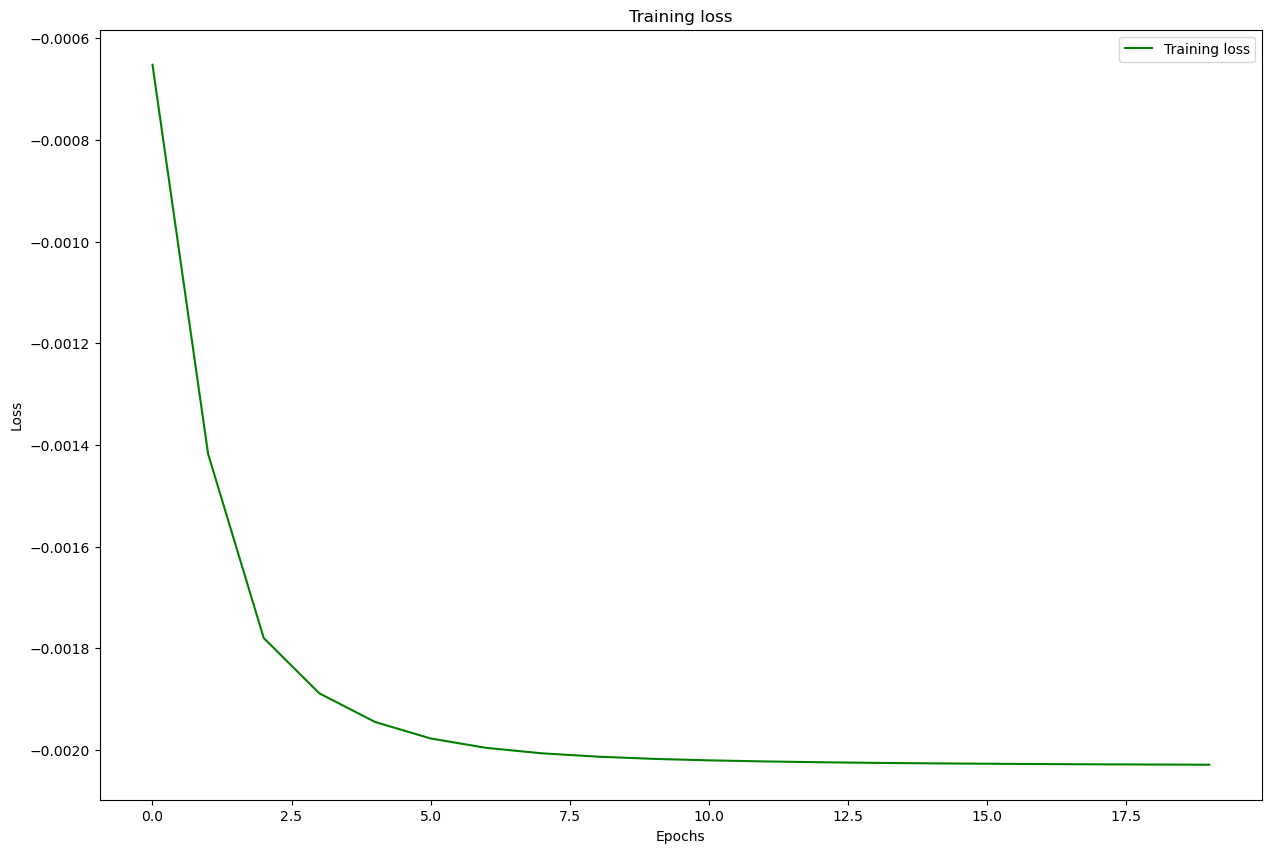

In [101]:
epochs = 20
n_paths = 150
plt.figure(figsize=(15,10))
plt.plot([np.mean(losses_robu_lstm[i*n_paths:(i+1)*n_paths]) for i in range(epochs)], 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Testing with different N° of buckets and Risk Aversion values

In [102]:
initial_wealth = 100000  # Initial wealth
fee_tier = 0.05  # Fee tier
RobustLSTMmodel_returns = [evaluate_RobustRNNmodel(RobustLSTMmodel, id, initial_wealth, fee_tier)[0] for id in range(100,500)]
final_return = np.mean(RobustLSTMmodel_returns)
print(f"Final expected return : {round(100*final_return,2)}%")

Final expected return : 8.42%


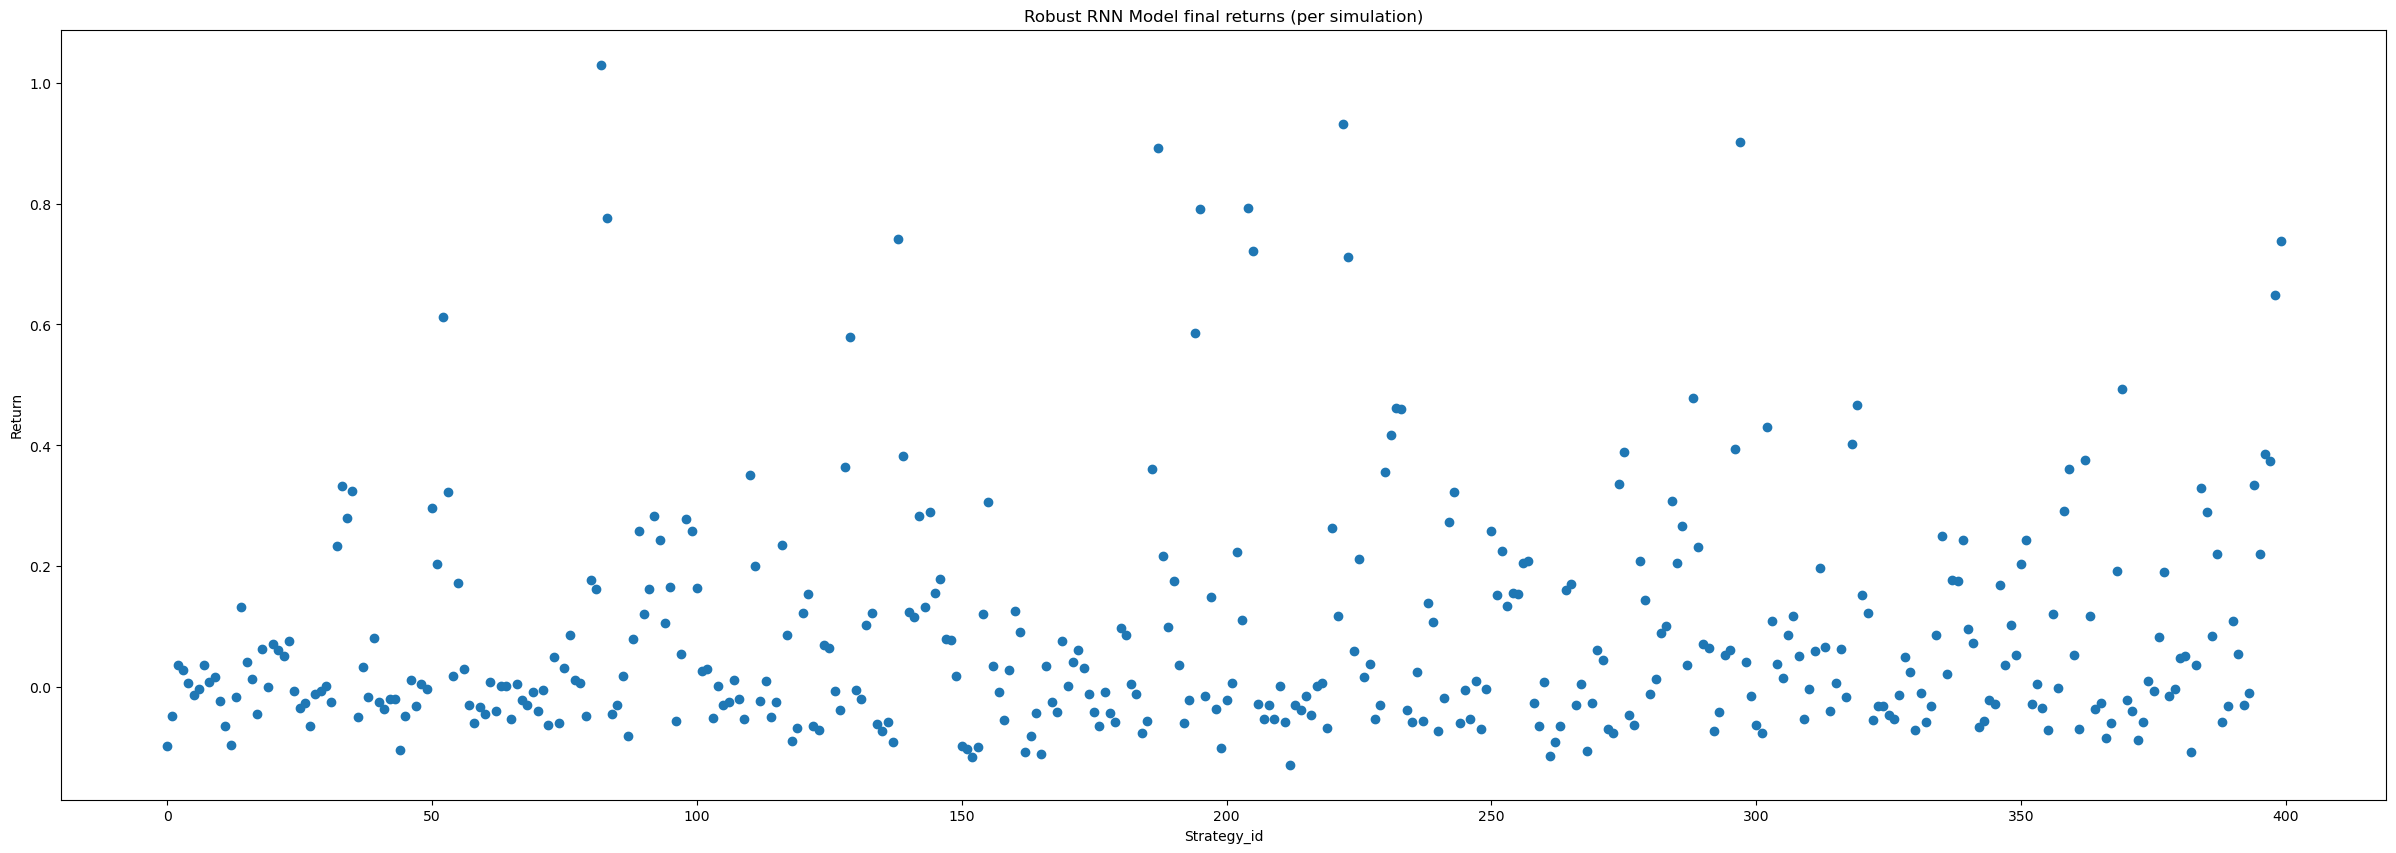

In [103]:
plt.figure(figsize=(30,10))
indexes = list(range(len(RobustLSTMmodel_returns)))
plt.scatter(indexes,RobustLSTMmodel_returns)
plt.title("Robust LSTM Model final returns (per simulation)")
plt.xlabel("Strategy_id")
plt.ylabel("Return")
plt.show()

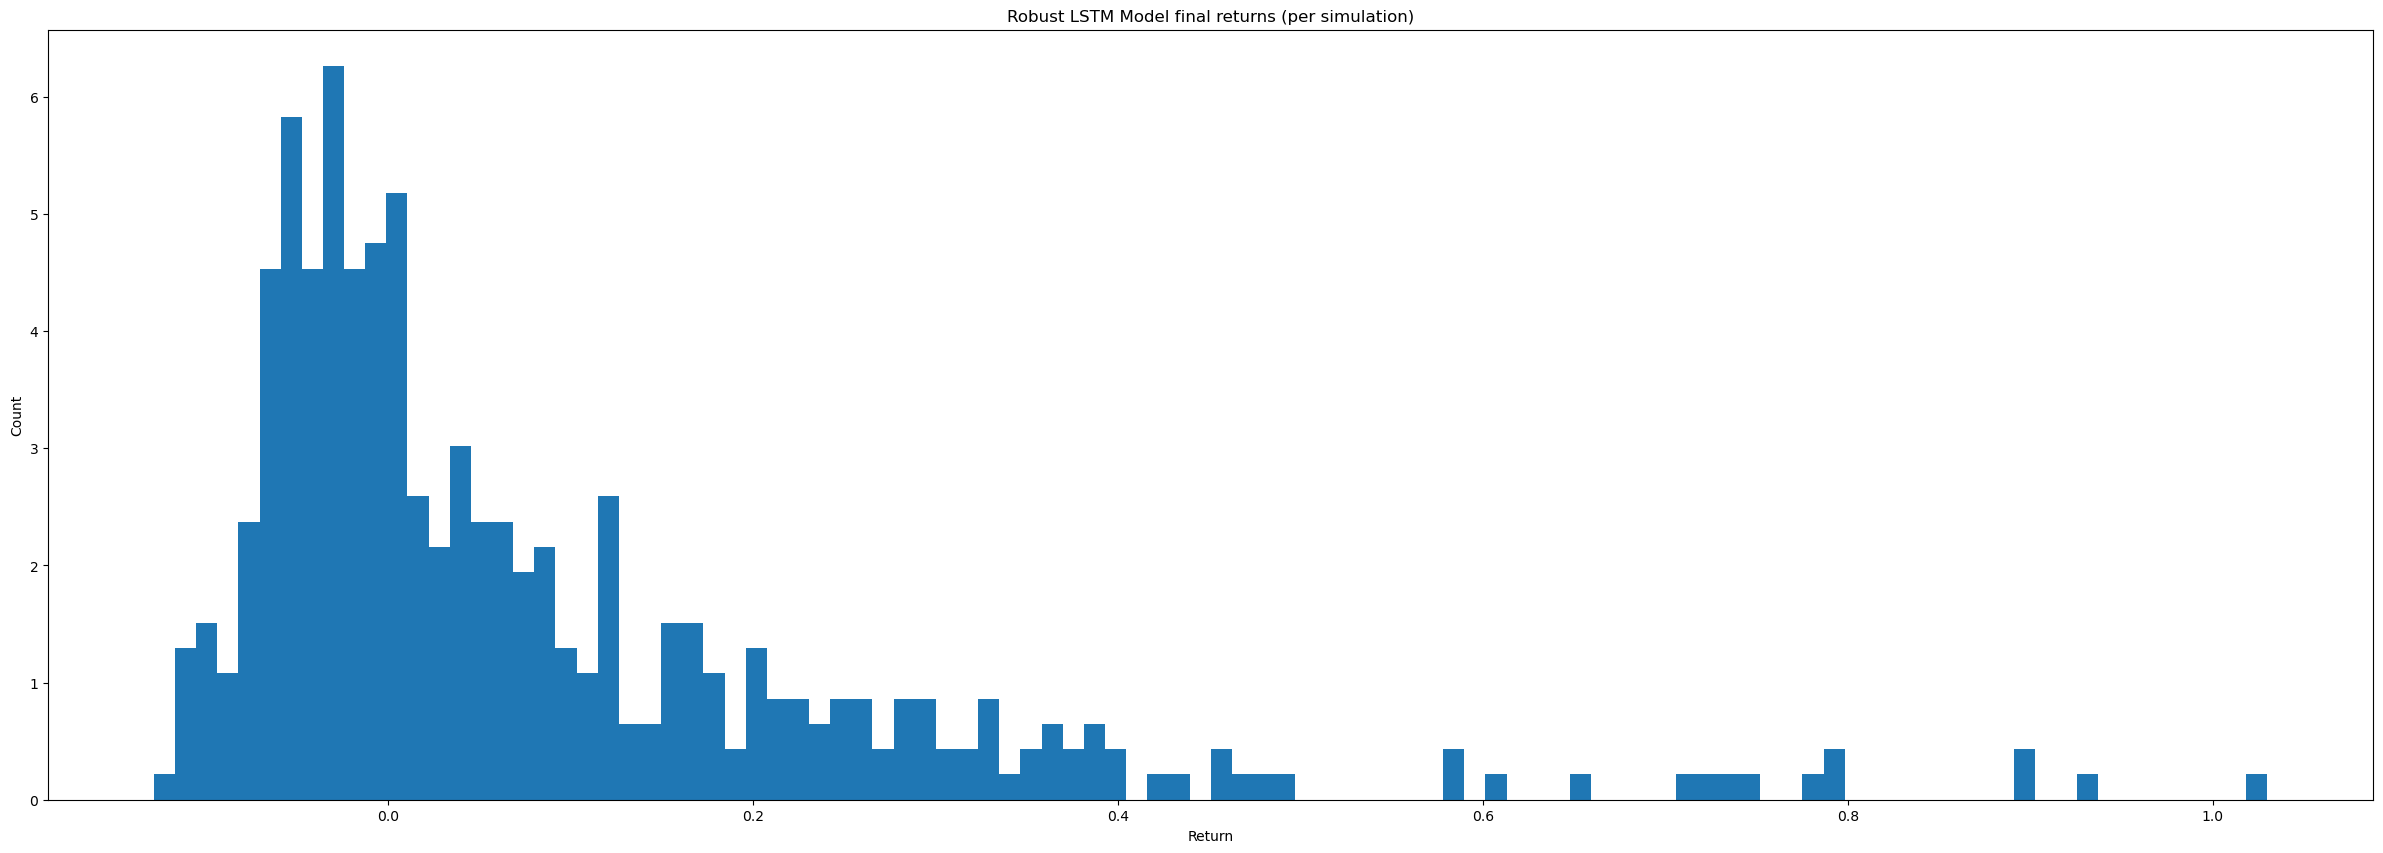

In [105]:
plt.figure(figsize=(30,10))
plt.hist(RobustLSTMmodel_returns, density=True, bins=100)
plt.title("Robust LSTM Model final returns (per simulation)")
plt.xlabel("Return")
plt.ylabel("Count")
plt.show()

In [121]:
tau = 20
hidden_size = 16
first_alloc_ts = 600
RobustLSTMmodel = RobustLSTMAllocationNetwork(first_alloc_ts=first_alloc_ts, tau=tau, input_size=1, hidden_size=hidden_size, num_layers=2)
fee_tier = 0.05
a = 500
# Train the model
losses_robu_lstm = RobustLSTM_train_model(RobustLSTMmodel, a, fee_tier, num_epochs=20, num_paths=150, lr=0.001)

Epoch 0, Loss: 1.4932676728373433e-05
Epoch 1, Loss: -0.0001515799998245863
Epoch 2, Loss: -0.0002137913906967507
Epoch 3, Loss: -0.00024220705048567955
Epoch 4, Loss: -0.0002534192076919813
Epoch 5, Loss: -0.0002589317787806067
Epoch 6, Loss: -0.00026304322384627693
Epoch 7, Loss: -0.0002656562087001172
Epoch 8, Loss: -0.000267670323407098
Epoch 9, Loss: -0.0002692333410353361
Epoch 10, Loss: -0.00027061343948541134
Epoch 11, Loss: -0.0002718156157033983
Epoch 12, Loss: -0.0002726859560182978
Epoch 13, Loss: -0.00027343750095648524
Epoch 14, Loss: -0.00027433378986794804
Epoch 15, Loss: -0.00027495228006500837
Epoch 16, Loss: -0.00027537910690322555
Epoch 17, Loss: -0.0002758746070988612
Epoch 18, Loss: -0.00027632293771603147
Epoch 19, Loss: -0.00027663874962551444


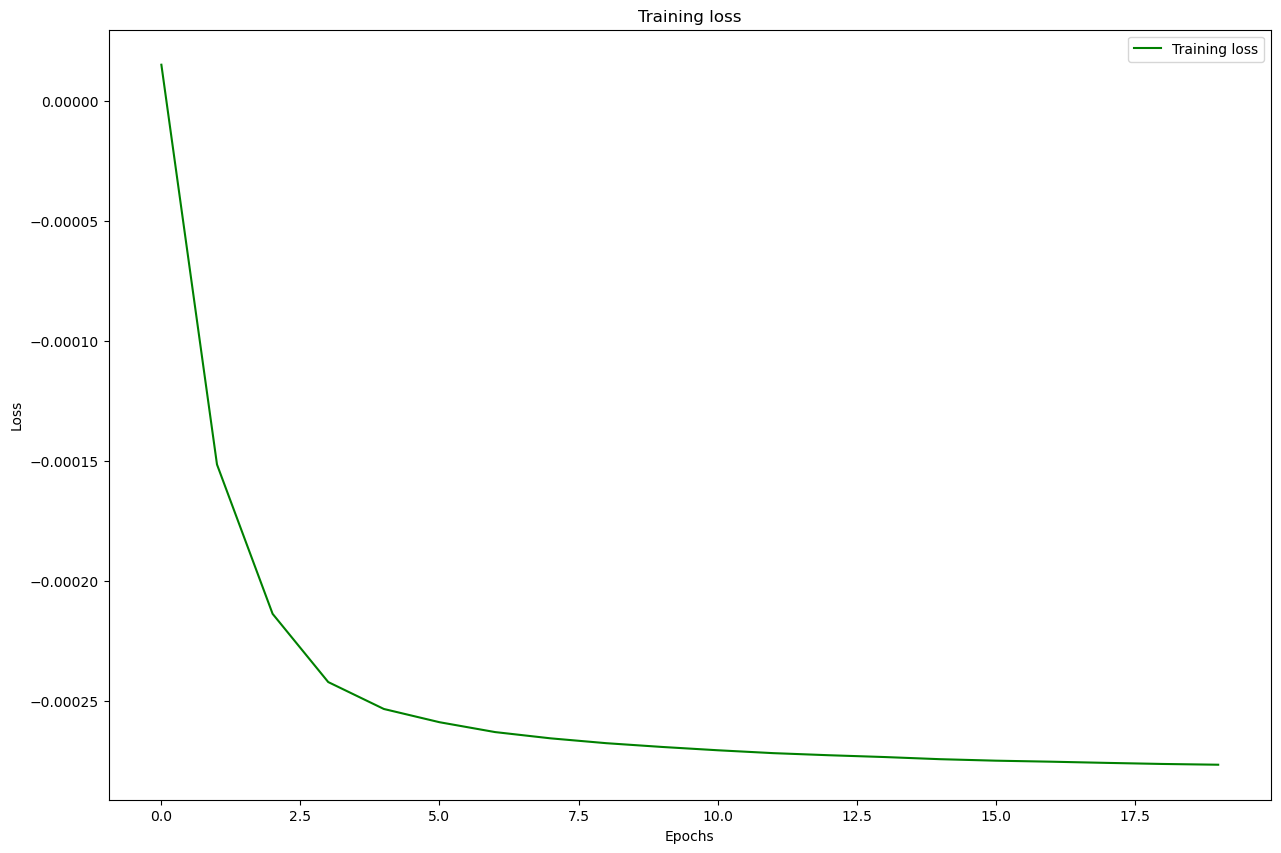

In [122]:
epochs = 20
n_paths = 150
plt.figure(figsize=(15,10))
plt.plot([np.mean(losses_robu_lstm[i*n_paths:(i+1)*n_paths]) for i in range(epochs)], 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [123]:
initial_wealth = 100000  # Initial wealth
fee_tier = 0.05  # Fee tier
RobustLSTMmodel_returns = [evaluate_RobustRNNmodel(RobustLSTMmodel, id, initial_wealth, fee_tier)[0] for id in range(100,500)]
final_return = np.mean(RobustLSTMmodel_returns)
print(f"Final expected return : {round(100*final_return,2)}%")

Final expected return : 4.08%


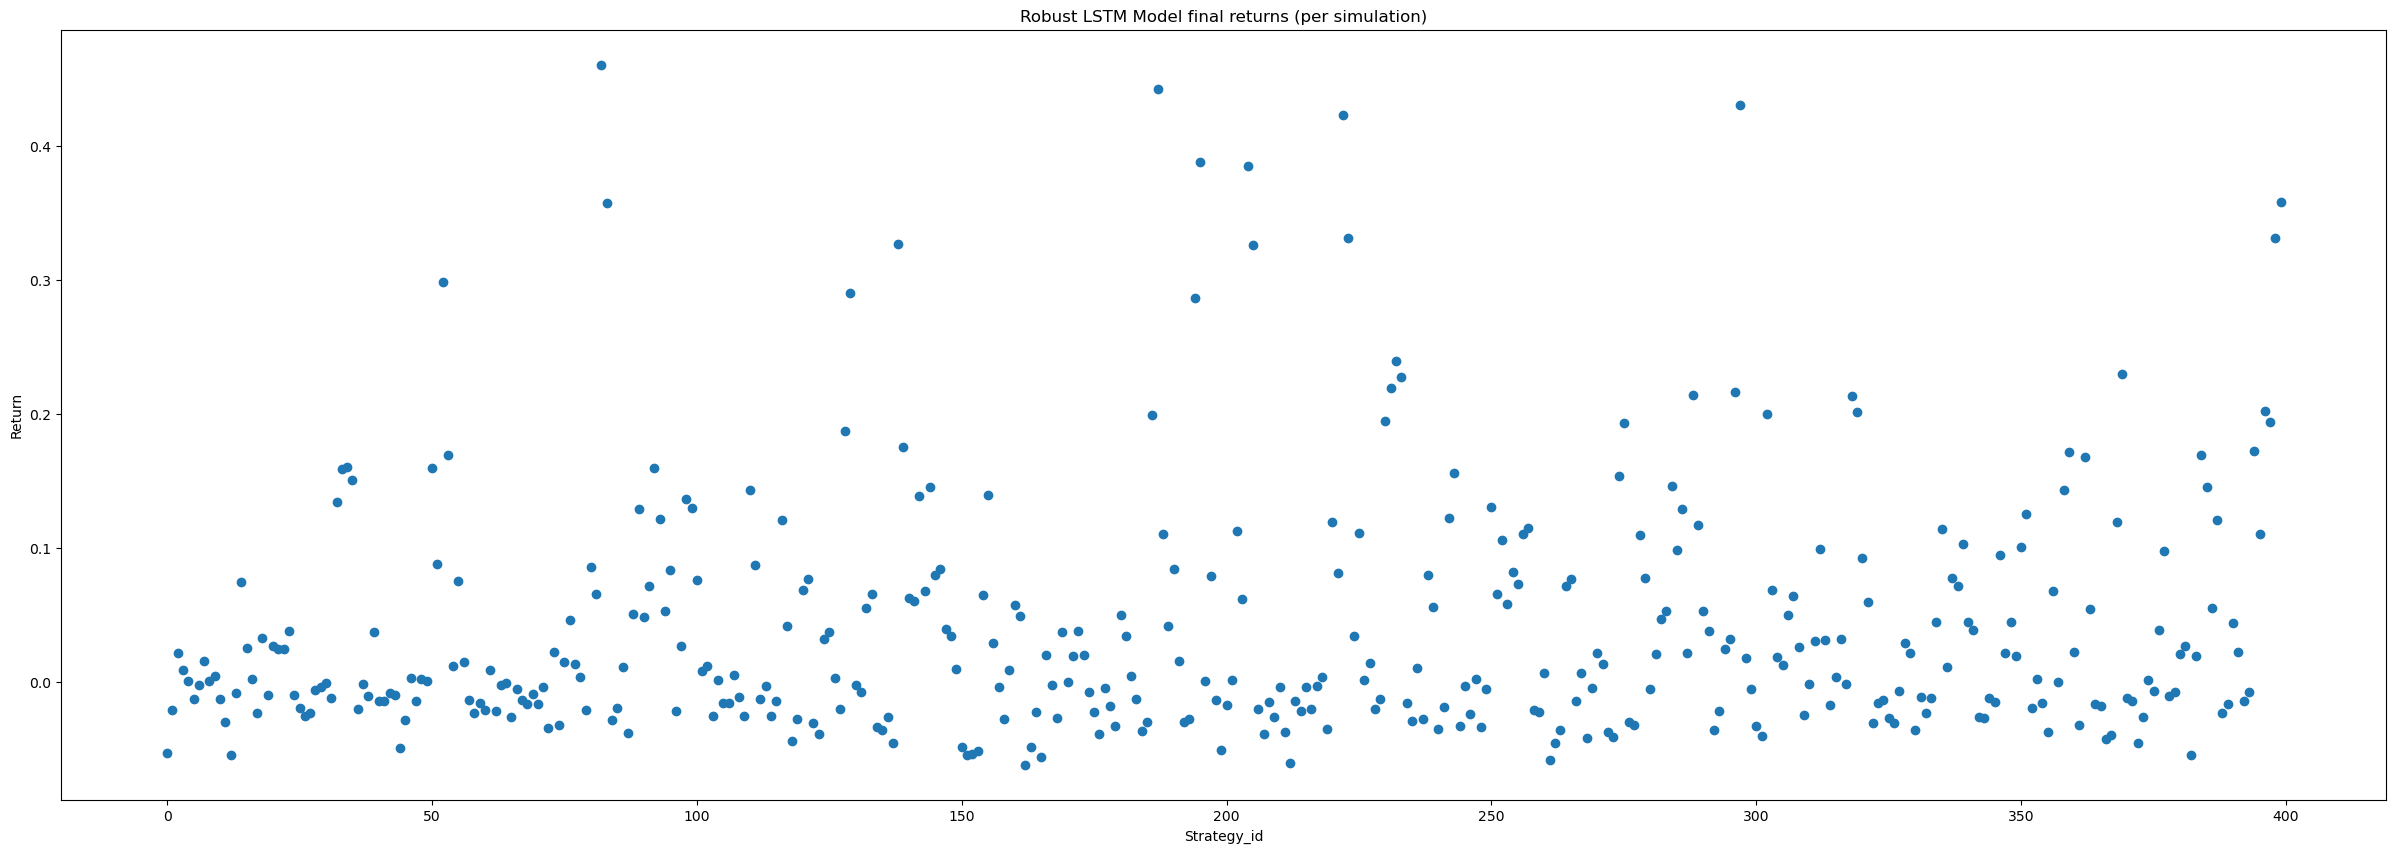

In [124]:
plt.figure(figsize=(30,10))
indexes = list(range(len(RobustLSTMmodel_returns)))
plt.scatter(indexes,RobustLSTMmodel_returns)
plt.title("Robust LSTM Model final returns (per simulation)")
plt.xlabel("Strategy_id")
plt.ylabel("Return")
plt.show()

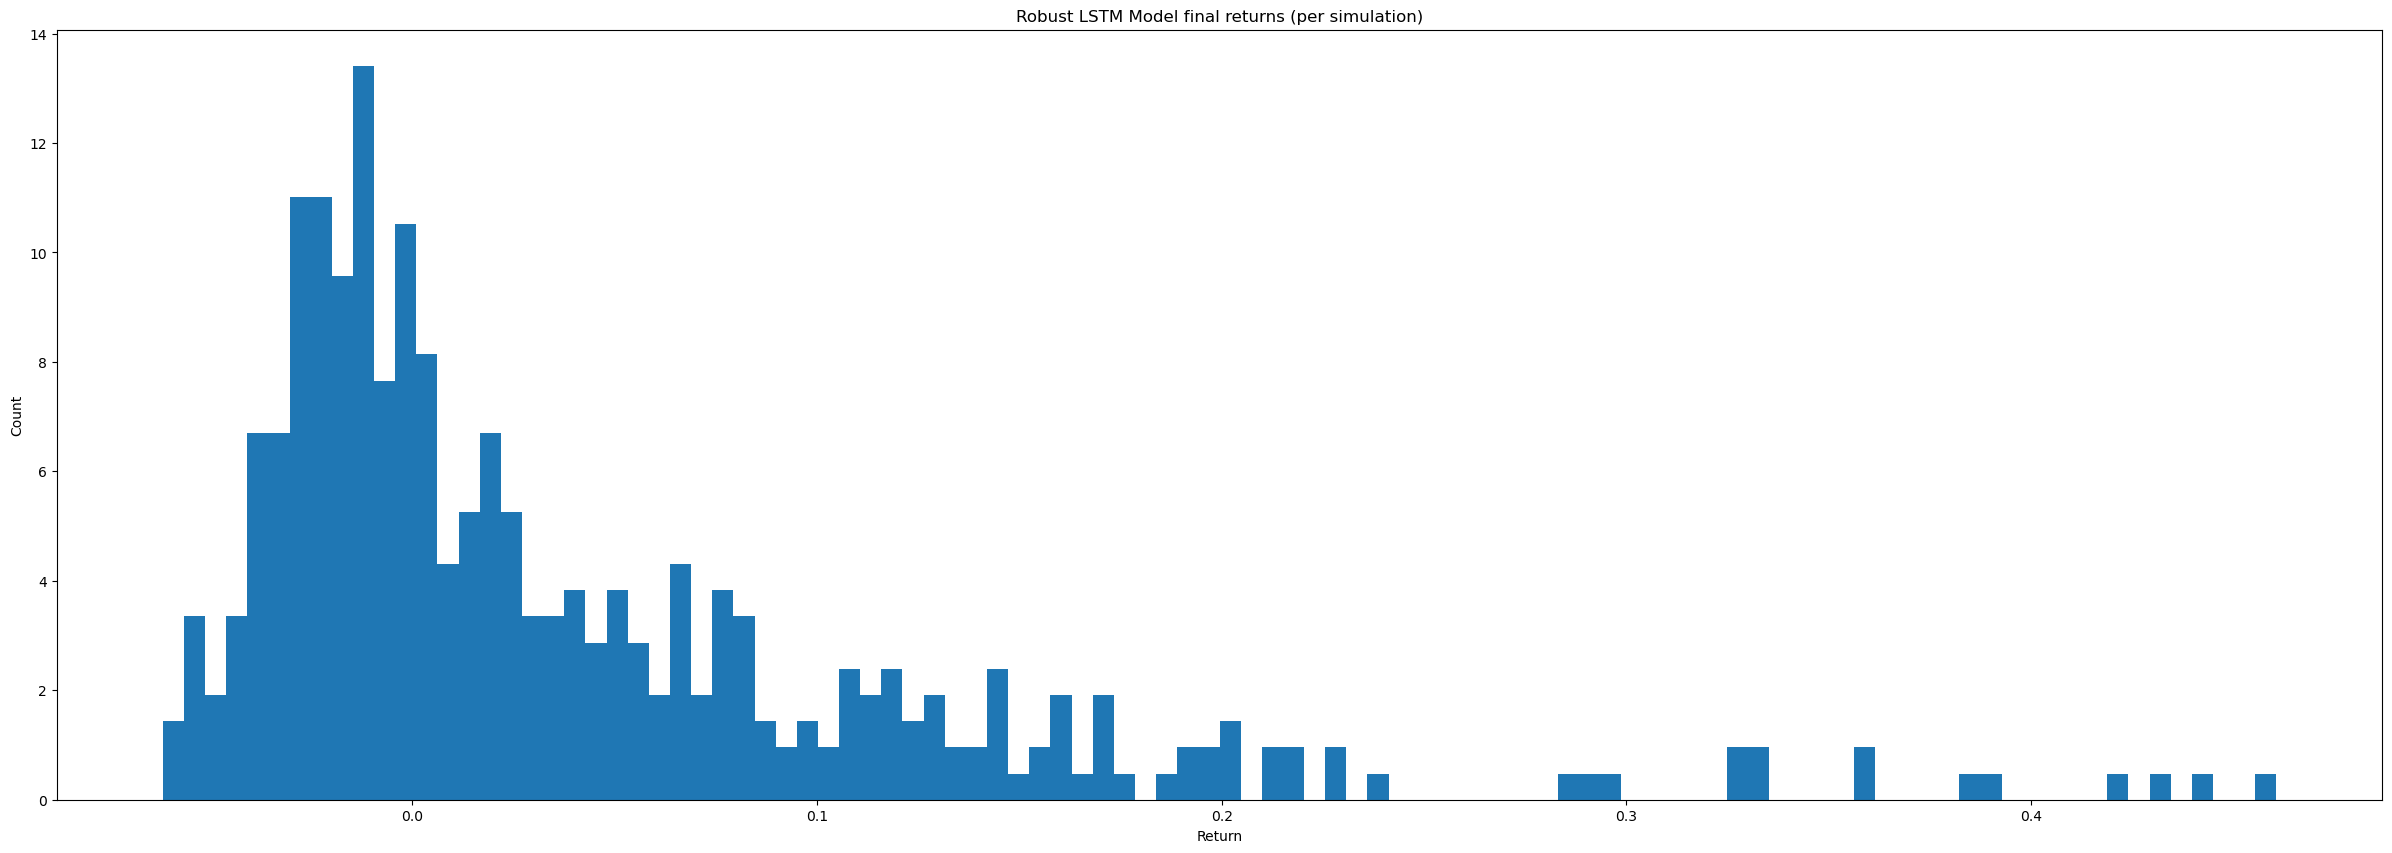

In [125]:
plt.figure(figsize=(30,10))
plt.hist(RobustLSTMmodel_returns, density=True, bins=100)
plt.title("Robust LSTM Model final returns (per simulation)")
plt.xlabel("Return")
plt.ylabel("Count")
plt.show()

In [129]:
loss = 0
for r in RobustLSTMmodel_returns:
    loss += r>0
loss/len(RobustLSTMmodel_returns)

0.5575

In [137]:
np.quantile(np.array(RobustLSTMmodel_returns),0.44)

-0.0005719472351483995

In [22]:
contract = pd.read_csv('../../total_historical_swaps.csv', index_col=0)


In [23]:
contract = contract[['timestamp', 'price']]

In [24]:
contract['timestamp'] = pd.to_datetime(contract['timestamp'])

In [25]:
grouped = contract.groupby(contract['timestamp'].dt.date)['price'].apply(list).reset_index()[:].reset_index()

In [26]:
transition = single_price_paths

In [27]:
single_price_paths = {i: np.array(row['price']) for i,row in grouped.iterrows()}

In [29]:
lens_true = [len(transition[id]) for id in range(len(transition))]

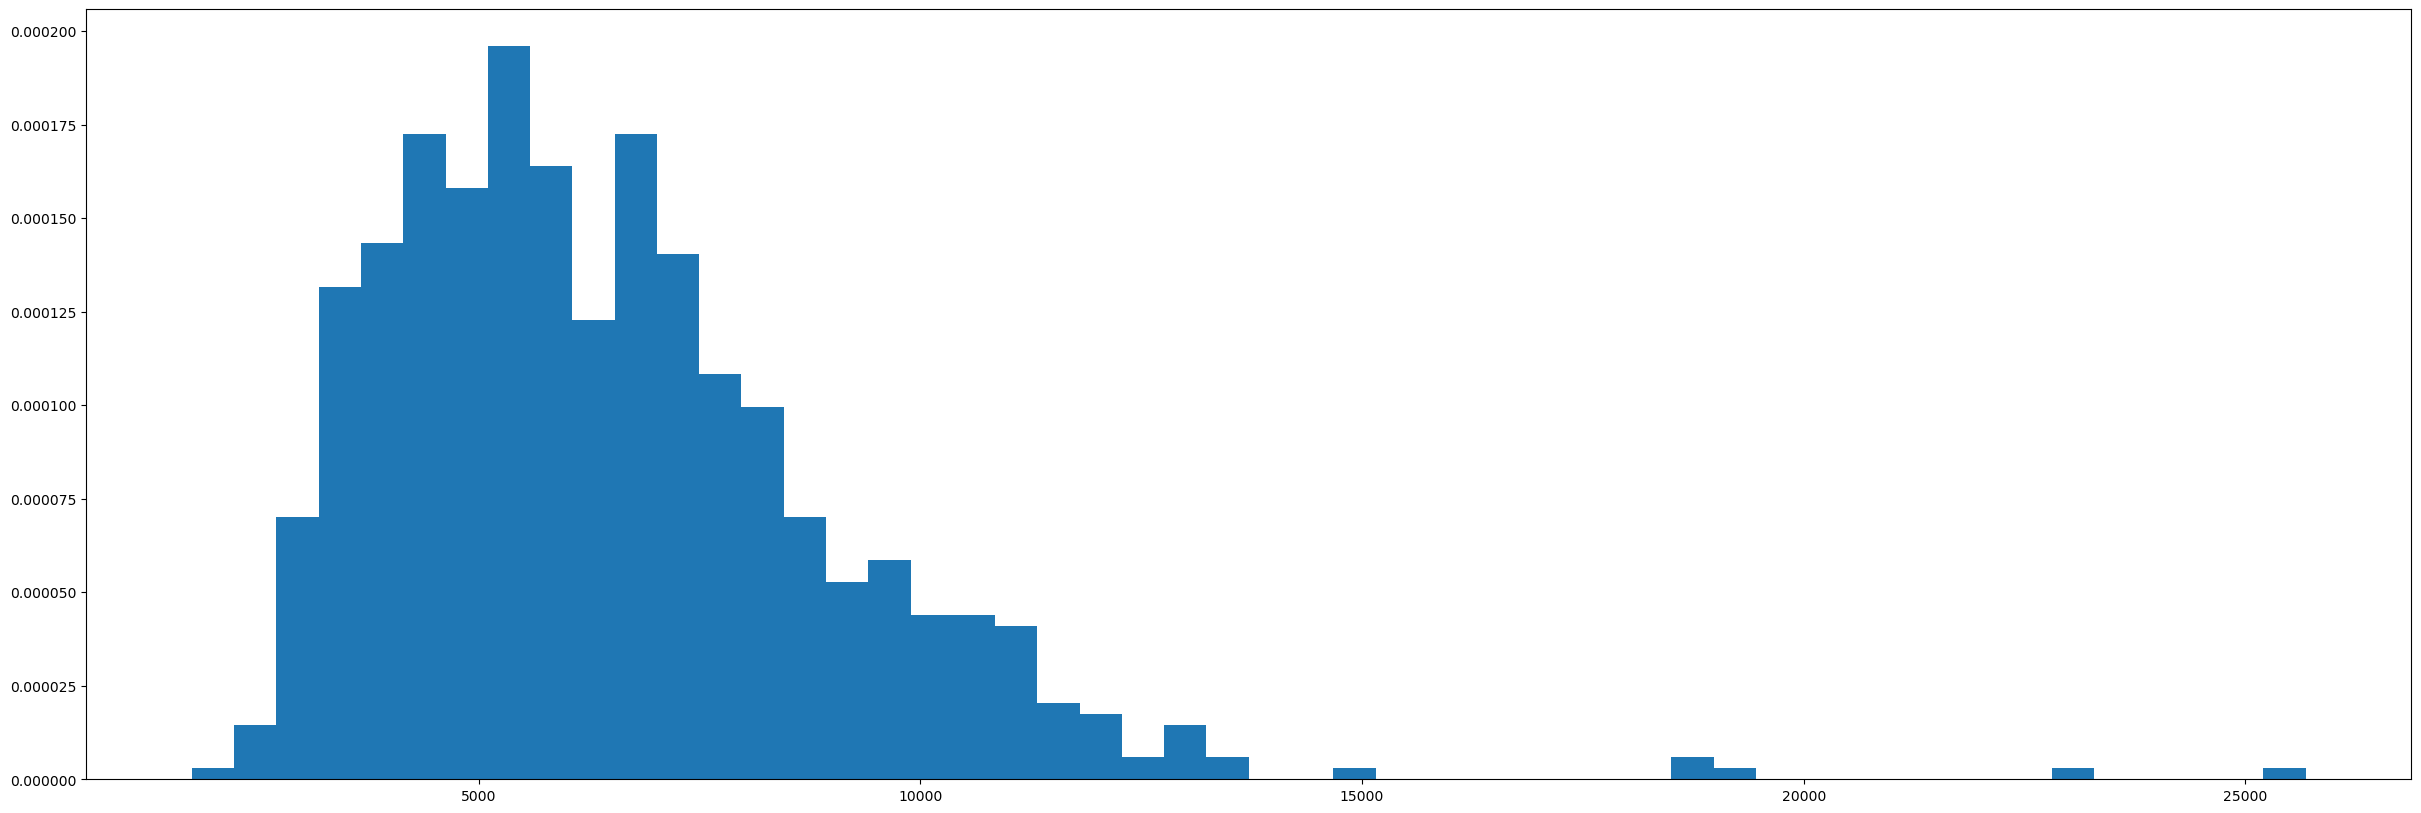

In [30]:
plt.figure(figsize=(30,10))
plt.hist(lens_true, density=True, bins=50)

plt.show()

In [163]:
tau = 20
hidden_size = 16
first_alloc_ts = 600
model = RobustRNNAllocationNetwork(first_alloc_ts=first_alloc_ts, tau=tau, input_size=1, hidden_size=hidden_size, num_layers=2) #empty model just to get the relevant parameters
initial_wealth = 100000  # Initial wealth
fee_tier = 0.05  # Fee tier
Constantmodel_returns = [evaluate_Constantmodel(model, id, initial_wealth, fee_tier)[0] for id in range(100,500)]
constant_final_return = np.mean(Constantmodel_returns)
print(f"Final expected return : {round(100*constant_final_return,2)}%")

Final expected return : -3.3%


In [166]:
initial_wealth = 100000  # Initial wealth
fee_tier = 0.05  # Fee tier
RobustLSTMmodel_returns = [evaluate_RobustRNNmodel(RobustLSTMmodel, id, initial_wealth, fee_tier)[0] for id in range(100,500)]
final_return = np.mean(RobustLSTMmodel_returns)
print(f"Final expected return : {round(100*final_return,2)}%")

Final expected return : -0.0%


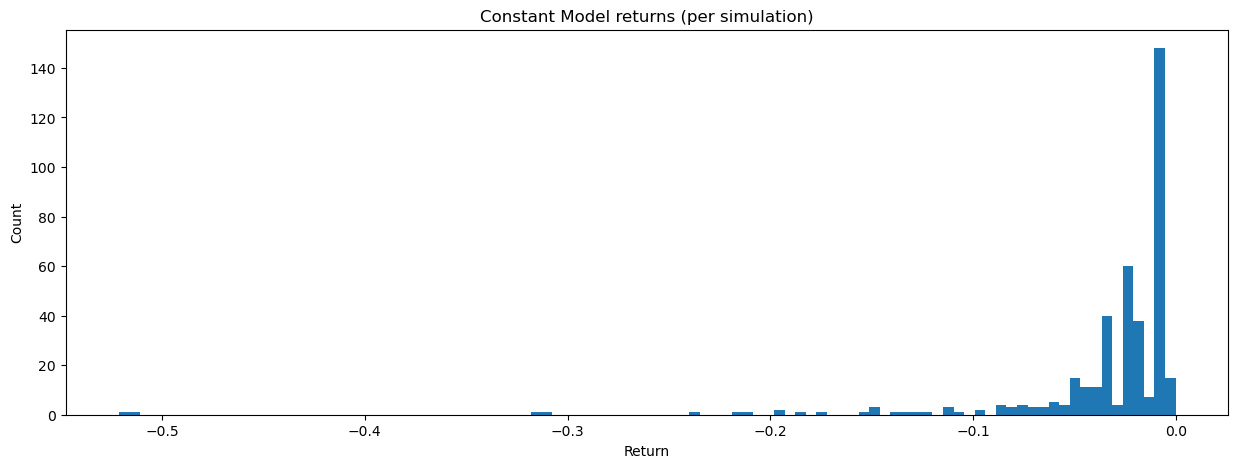

In [168]:
plt.figure(figsize=(15,5))
plt.hist(Constantmodel_returns, bins=100)
plt.title("Constant Model returns (per simulation)")
plt.xlabel("Return")
plt.ylabel("Count")
plt.show()

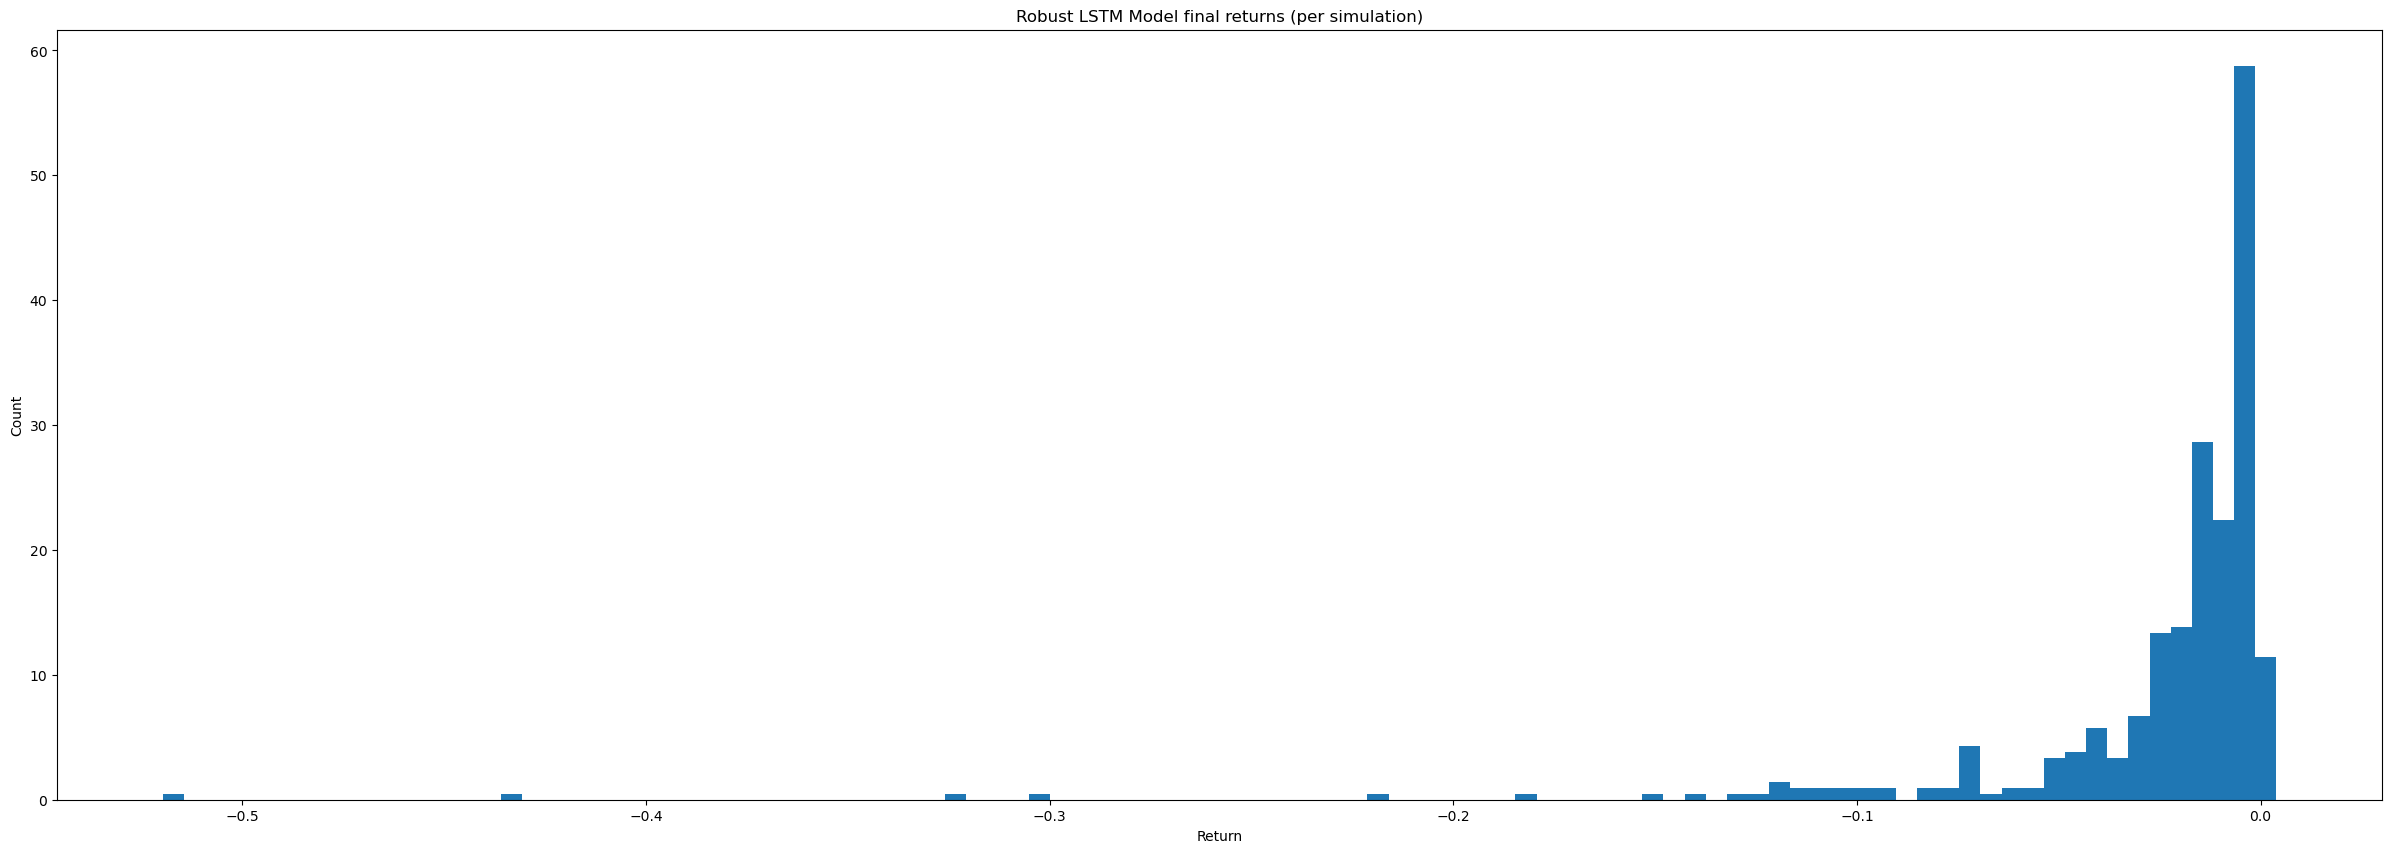

In [155]:
plt.figure(figsize=(30,10))
plt.hist(RobustLSTMmodel_returns, density=True, bins=100)
plt.title("Robust LSTM Model final returns (per simulation)")
plt.xlabel("Return")
plt.ylabel("Count")
plt.show()

In [156]:
len(single_price_paths[0])

7319

In [28]:
tau = 100
hidden_size = 16
first_alloc_ts = 200
RobustLSTMmodel = RobustLSTMAllocationNetwork(first_alloc_ts=first_alloc_ts, tau=tau, input_size=1, hidden_size=hidden_size, num_layers=2)
fee_tier = 0.05
a = 0
# Train the model
losses_robu_lstm = RobustLSTM_train_model(RobustLSTMmodel, a, fee_tier, num_epochs=20, num_paths=200, lr=0.01)

Epoch 0, Loss: -0.00013263484723722741
Epoch 1, Loss: -0.0002584357692903794
Epoch 2, Loss: -0.0002597198015541302
Epoch 3, Loss: -0.00025983704658994356
Epoch 4, Loss: -0.0002598664251940974
Epoch 5, Loss: -0.00025988065320135866
Epoch 6, Loss: -0.00025989213897117616
Epoch 7, Loss: -0.0002598984225329781
Epoch 8, Loss: -0.0002599070991756114
Epoch 9, Loss: -0.0002599103138717673
Epoch 10, Loss: -0.0002599142524777087
Epoch 11, Loss: -0.0002599167177345585
Epoch 12, Loss: -0.0002599193165560942
Epoch 13, Loss: -0.0002599190284262964
Epoch 14, Loss: -0.00025991848203115174
Epoch 15, Loss: -0.0002599240316758156
Epoch 16, Loss: -0.00025992068151451606
Epoch 17, Loss: -0.00025992210760159896
Epoch 18, Loss: -0.0002599227447183705
Epoch 19, Loss: -0.0002599225621019019


In [46]:
initial_wealth = 100000  # Initial wealth
fee_tier = 0.05  # Fee tier
RobustLSTMmodel_returns = [evaluate_RobustRNNmodel(RobustLSTMmodel, id, initial_wealth, fee_tier)[0] for id in range(200,400)]
final_return = np.mean(RobustLSTMmodel_returns)
print(f"Final expected return : {round(100*final_return,4)}%")

Final expected return : -0.0589%


In [44]:
np.quantile(np.array(RobustLSTMmodel_returns),0.7)

0.007352651003748177

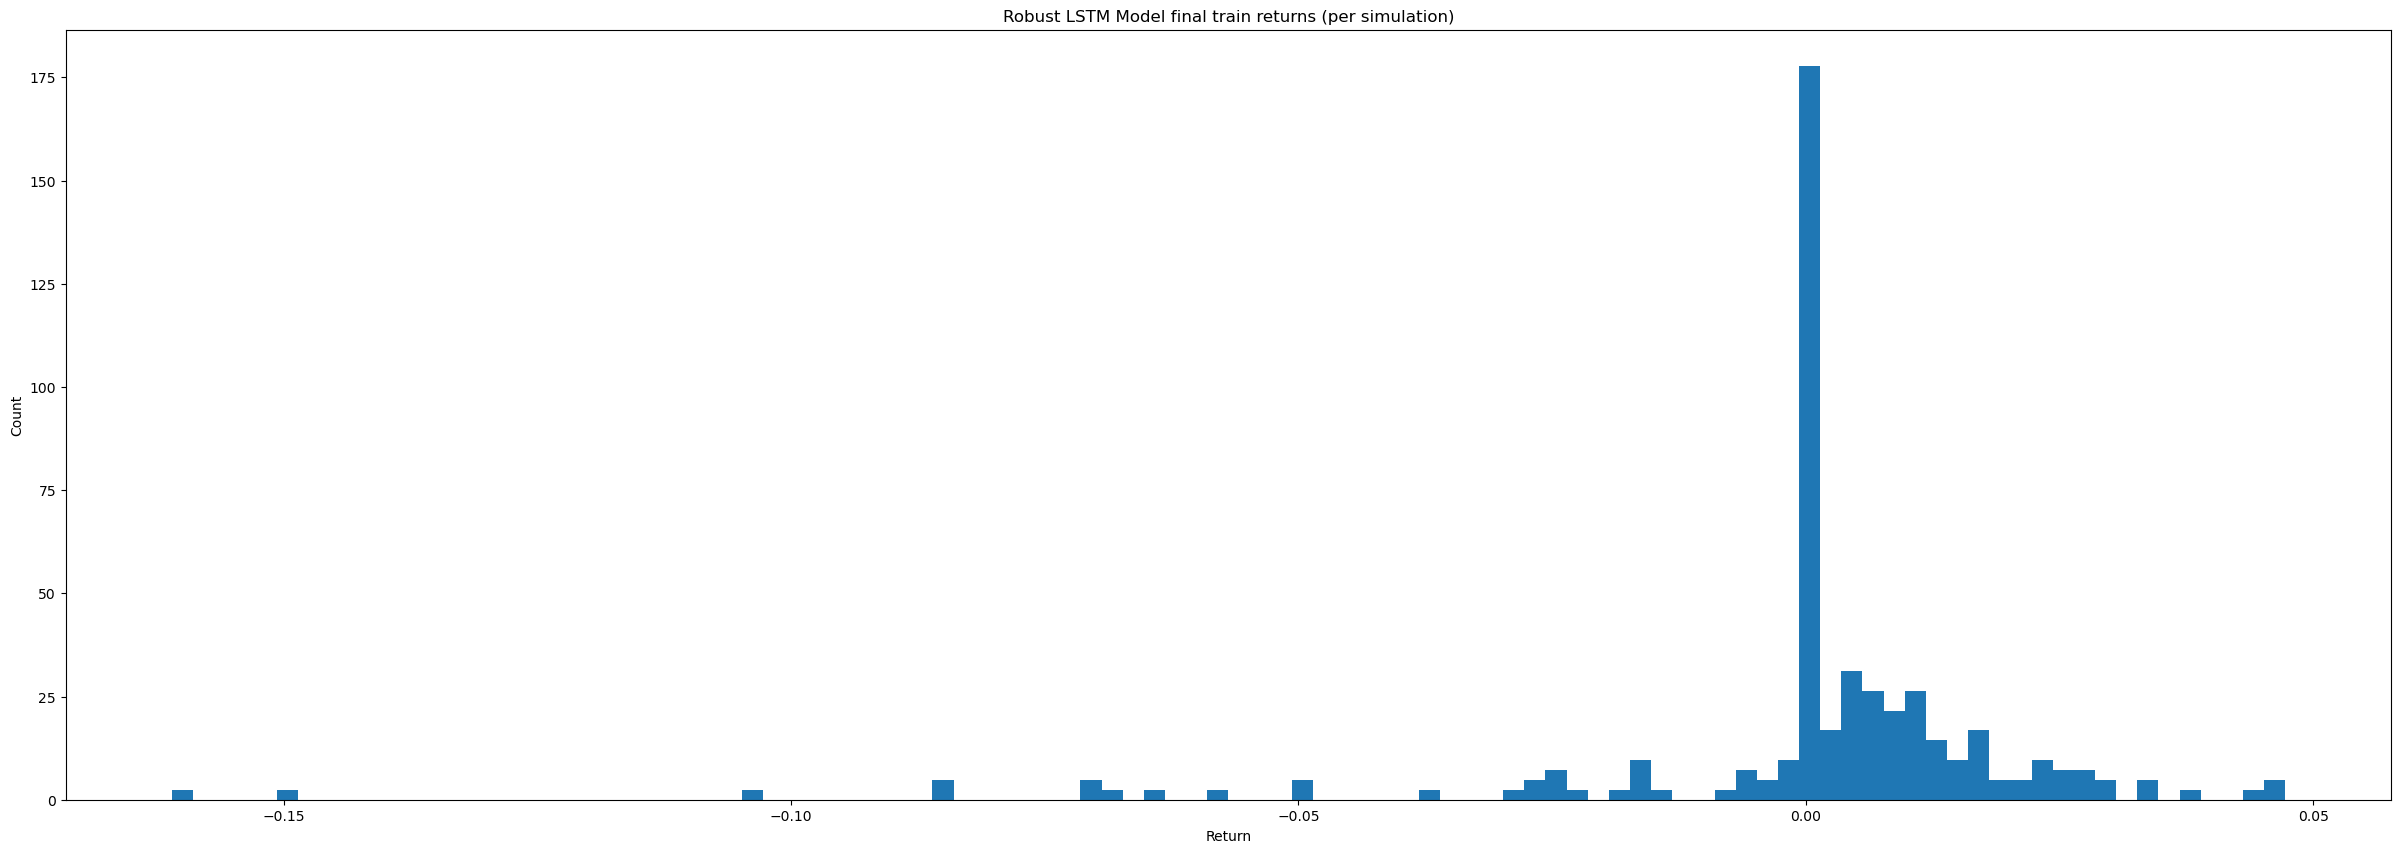

In [36]:
# Train
plt.figure(figsize=(30,10))
plt.hist(RobustLSTMmodel_returns, density=True, bins=100)
plt.title("Robust LSTM Model final train returns (per simulation)")
plt.xlabel("Return")
plt.ylabel("Count")
plt.show()

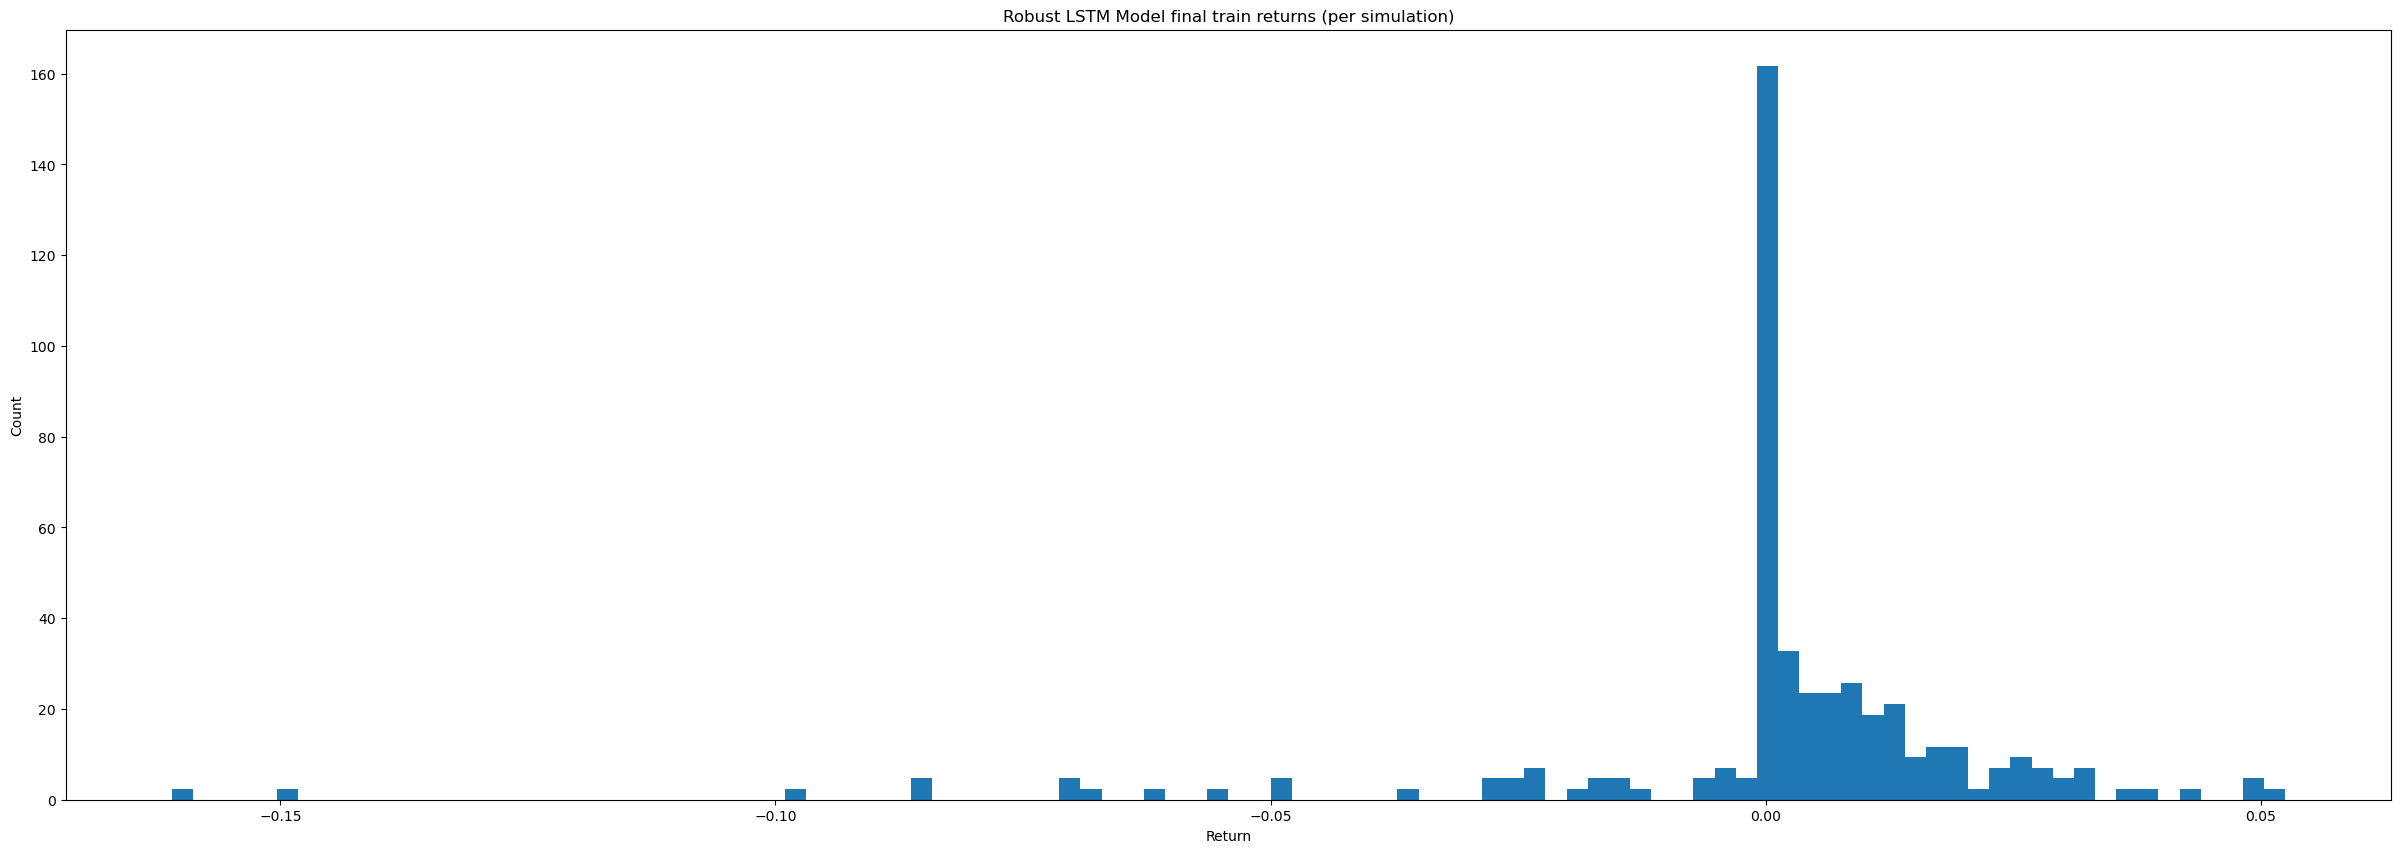

In [33]:
# Train
plt.figure(figsize=(30,10))
plt.hist(RobustLSTMmodel_returns, density=True, bins=100)
plt.title("Robust LSTM Model final train returns (per simulation)")
plt.xlabel("Return")
plt.ylabel("Count")
plt.show()

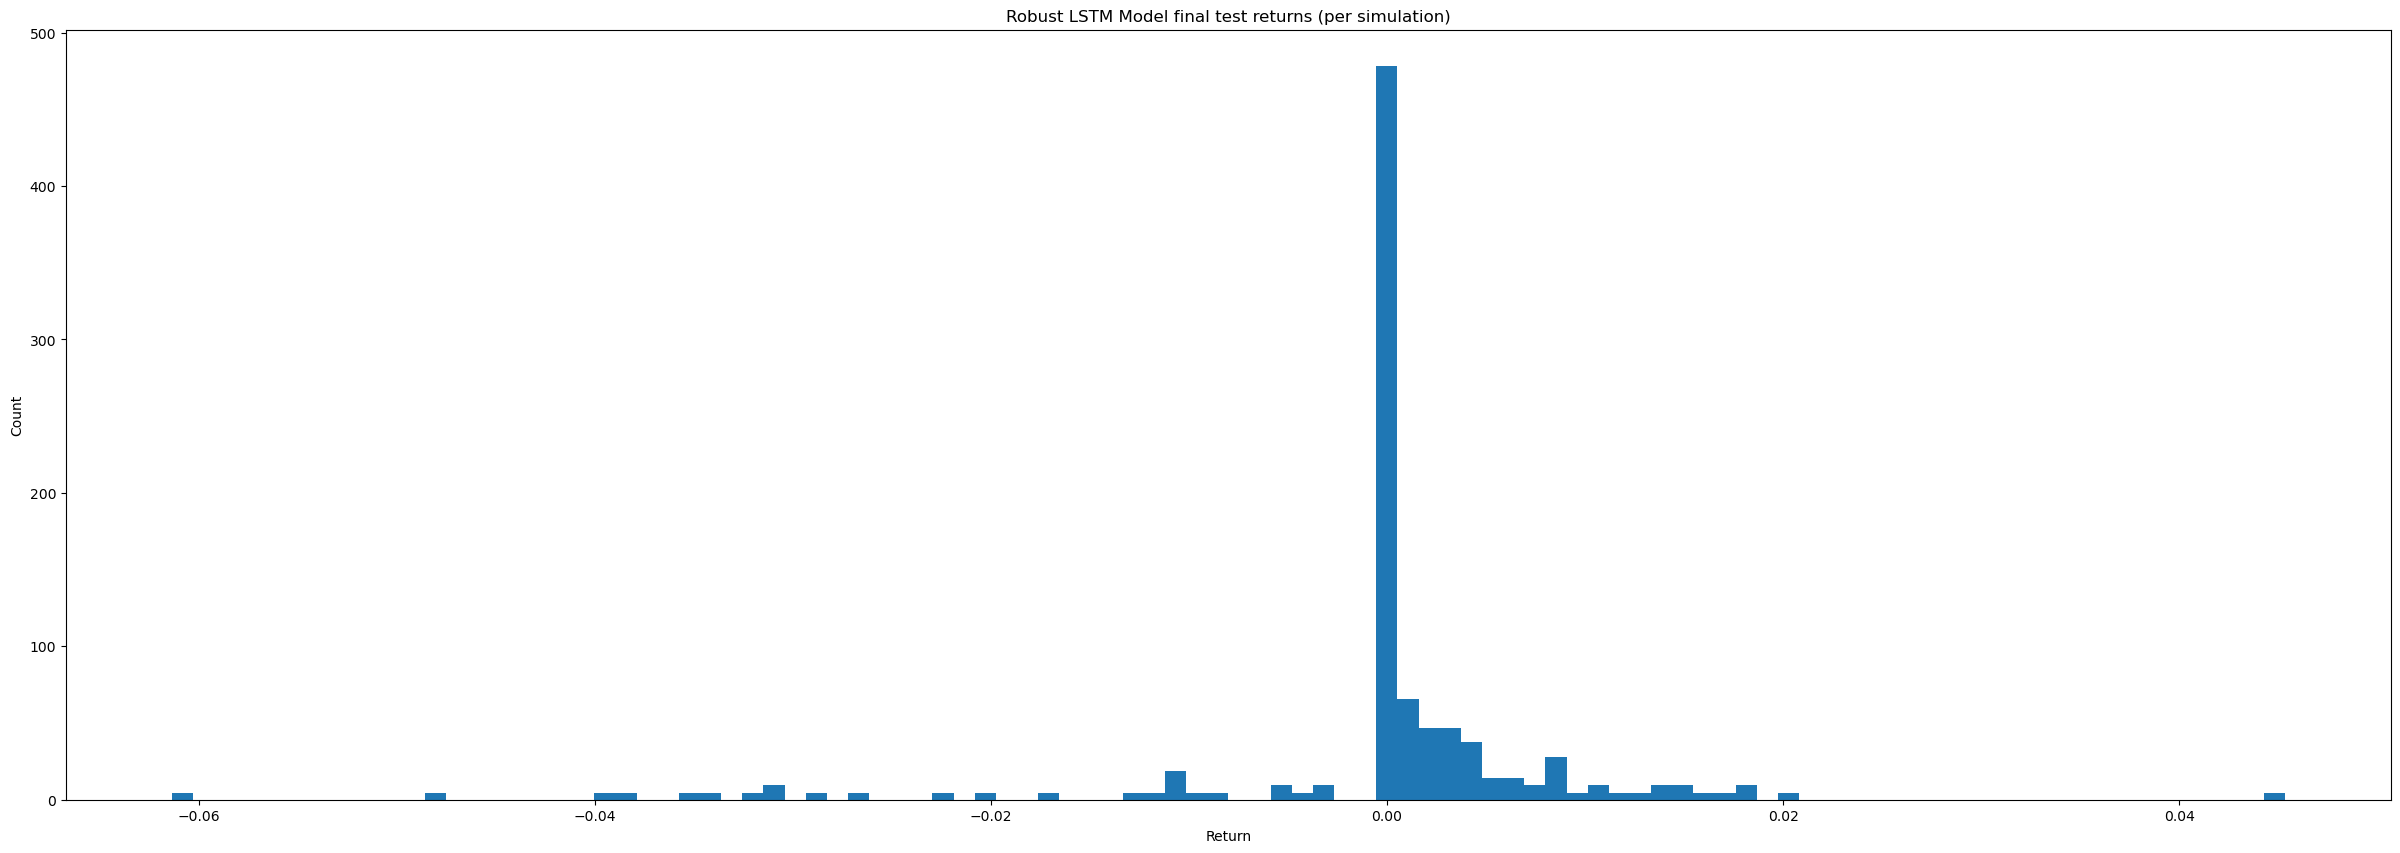

In [47]:
# Test
plt.figure(figsize=(30,10))
plt.hist(RobustLSTMmodel_returns, density=True, bins=100)
plt.title("Robust LSTM Model final test returns (per simulation)")
plt.xlabel("Return")
plt.ylabel("Count")
plt.show()

In [55]:
np.quantile(np.array(RobustLSTMmodel_returns),0.15)

-1.679686675970517e-07

In [ ]:
initial_wealth = 100000  # Initial wealth
fee_tier = 0.05  # Fee tier
RobustLSTMmodel_returns = [evaluate_RobustRNNmodel(RobustLSTMmodel, id, initial_wealth, fee_tier)[0] for id in range(200,400)]
final_return = np.mean(RobustLSTMmodel_returns)
print(f"Final expected return : {round(100*final_return,4)}%")

Final expected return : -0.0589%


In [ ]:
np.quantile(np.array(RobustLSTMmodel_returns),0.7)

0.007352651003748177

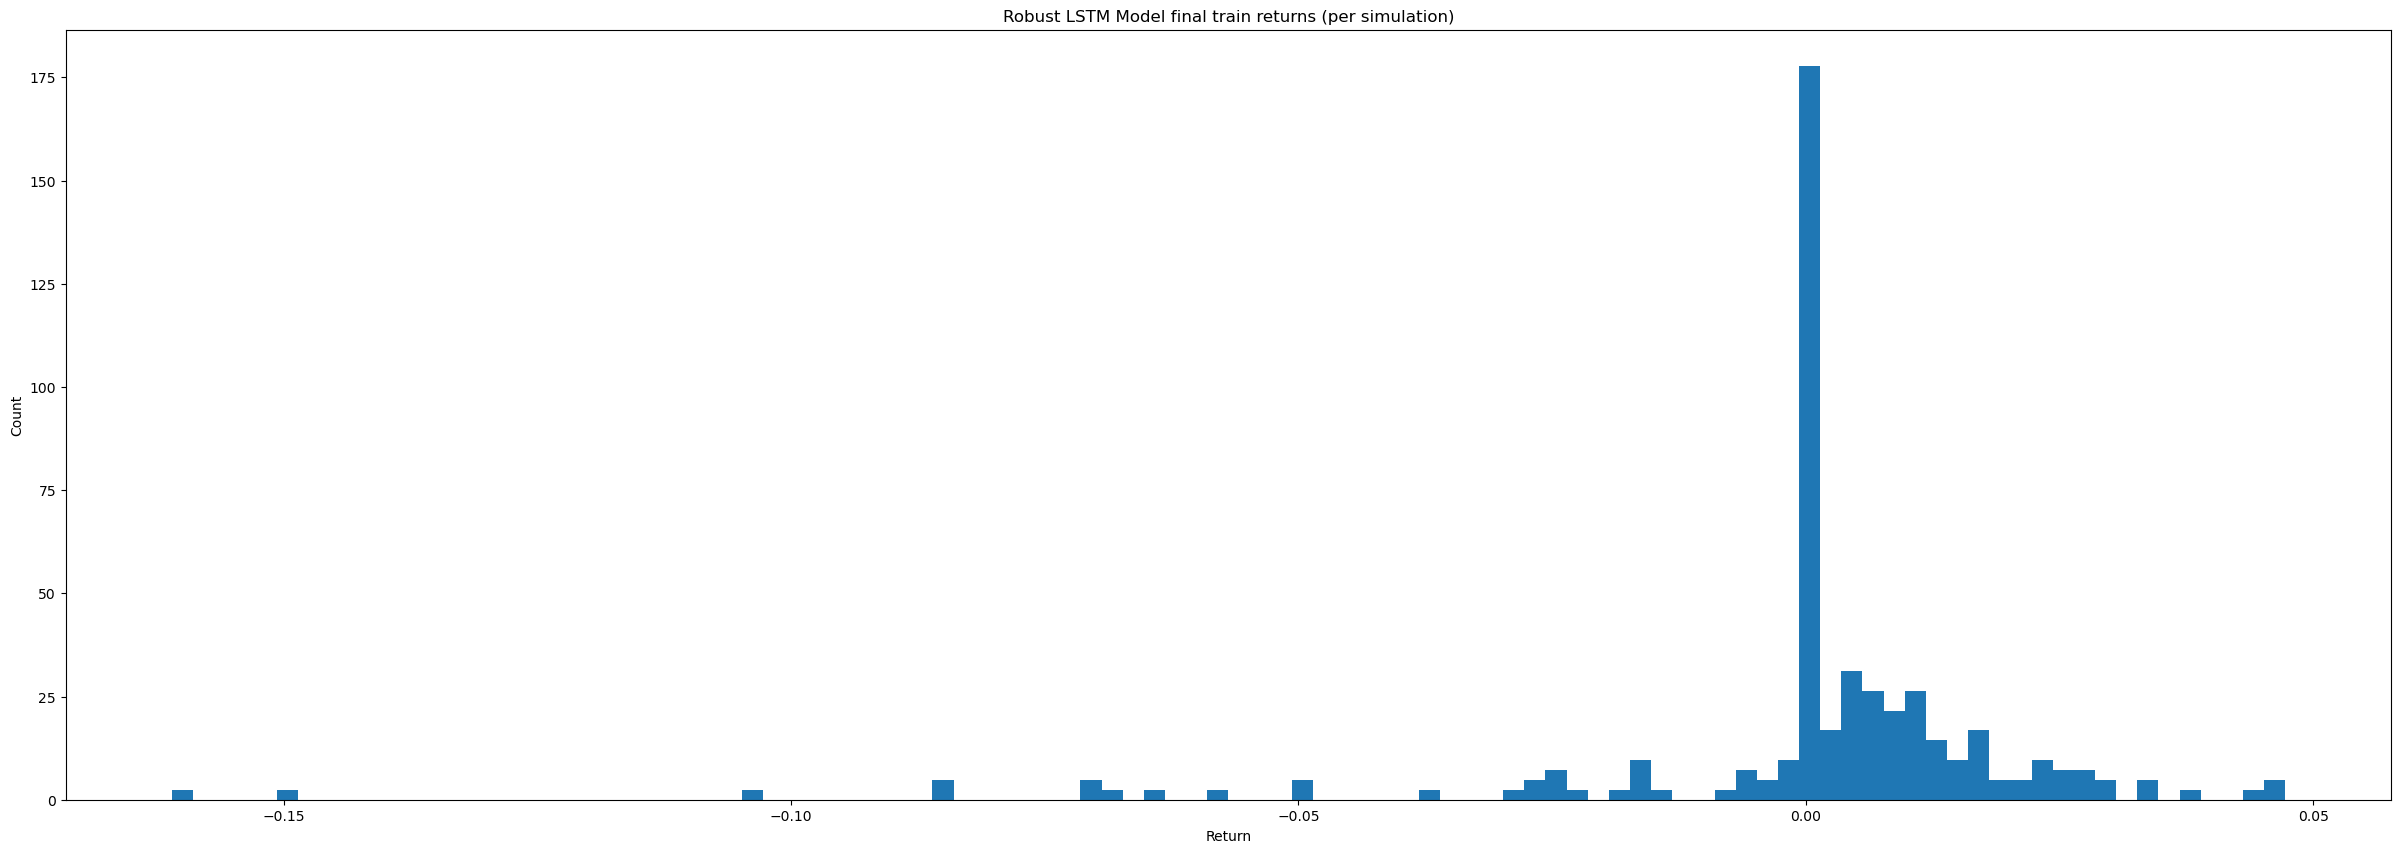

In [ ]:
# Train
plt.figure(figsize=(30,10))
plt.hist(RobustLSTMmodel_returns, density=True, bins=100)
plt.title("Robust LSTM Model final train returns (per simulation)")
plt.xlabel("Return")
plt.ylabel("Count")
plt.show()

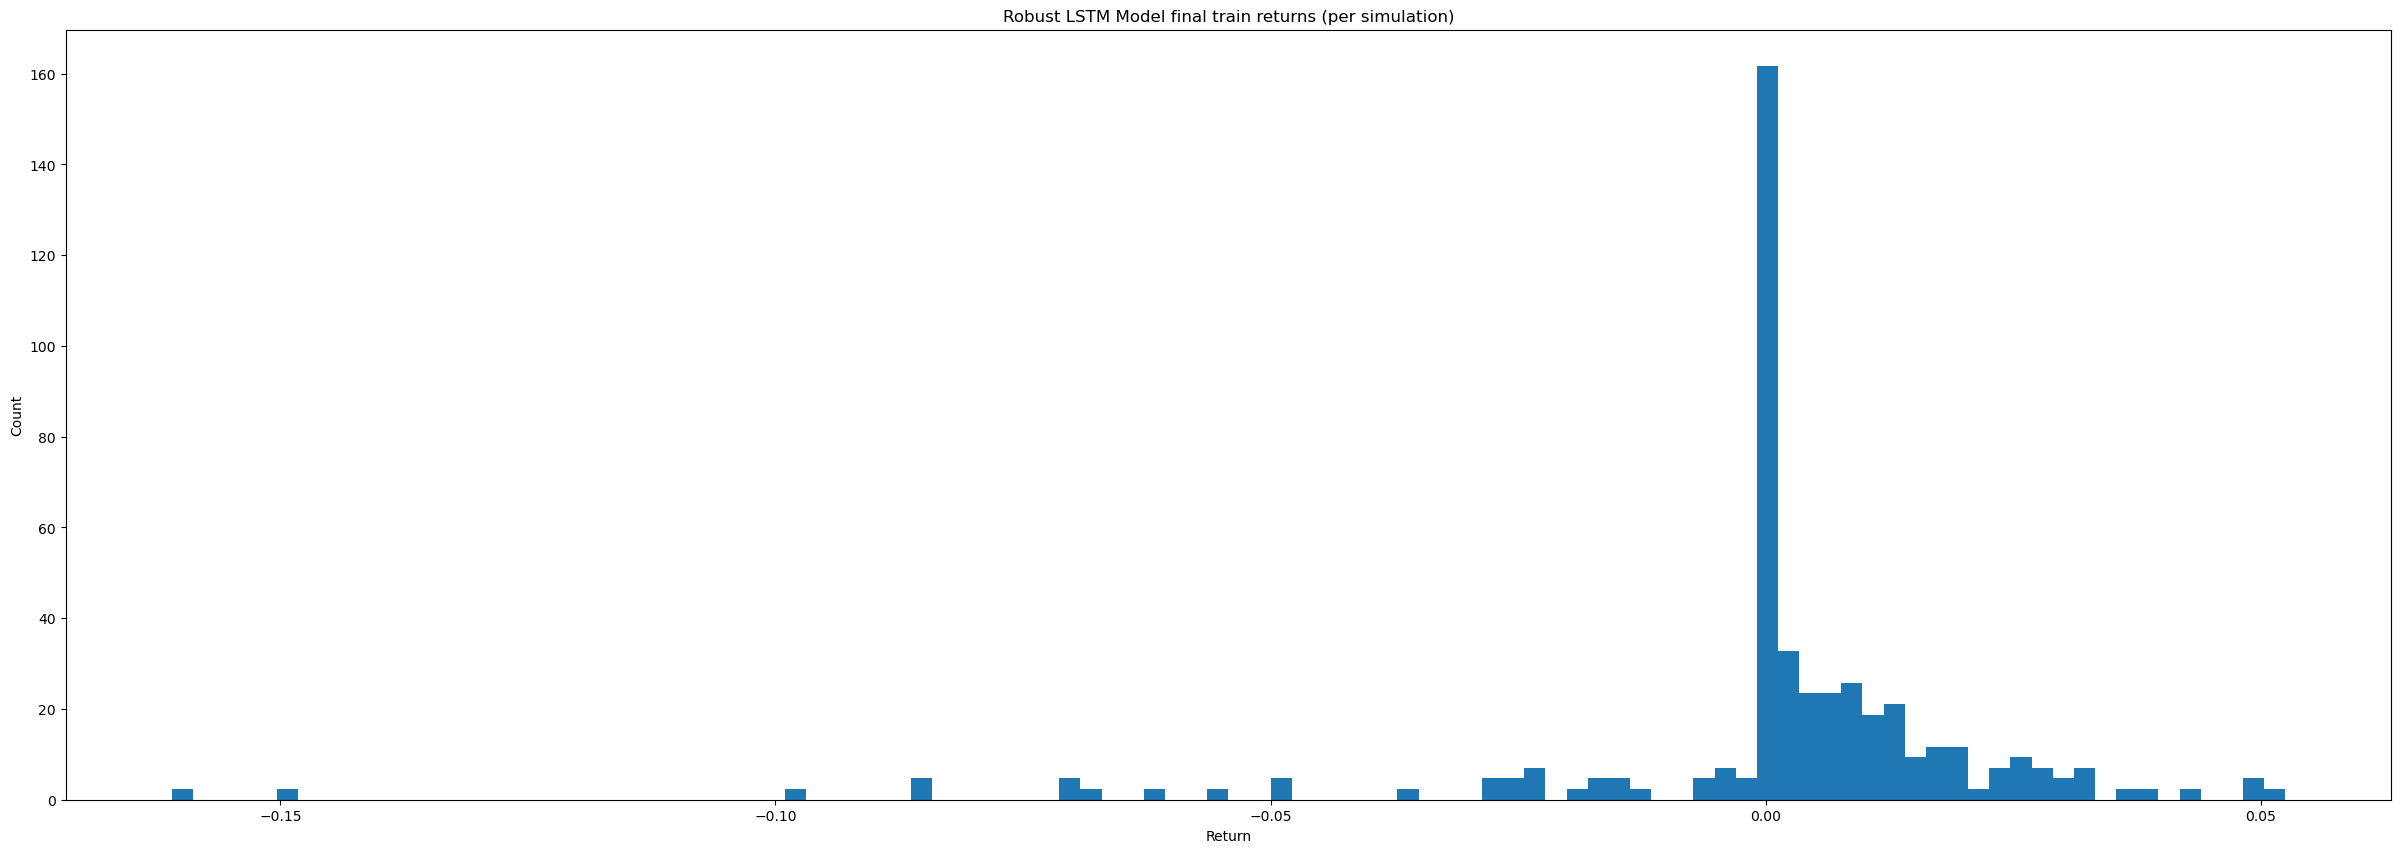

In [ ]:
# Train
plt.figure(figsize=(30,10))
plt.hist(RobustLSTMmodel_returns, density=True, bins=100)
plt.title("Robust LSTM Model final train returns (per simulation)")
plt.xlabel("Return")
plt.ylabel("Count")
plt.show()

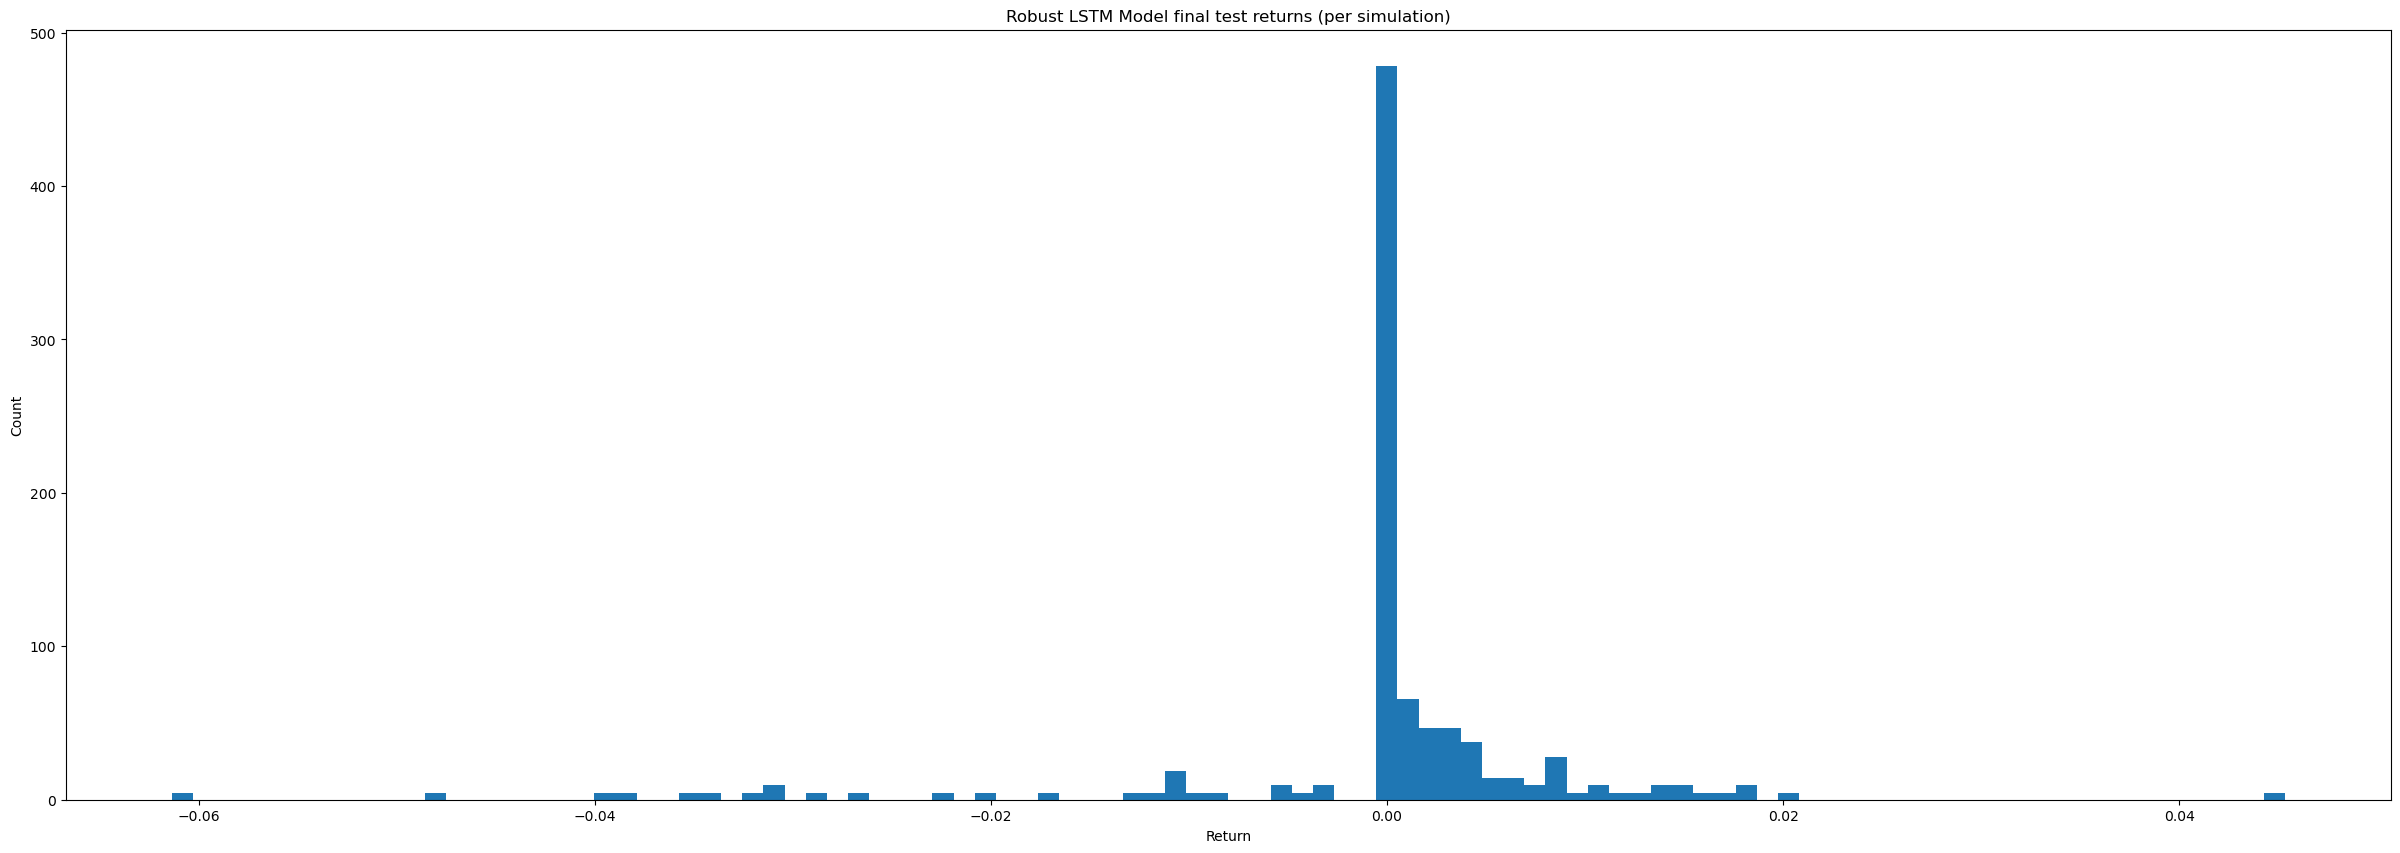

In [ ]:
# Test
plt.figure(figsize=(30,10))
plt.hist(RobustLSTMmodel_returns, density=True, bins=100)
plt.title("Robust LSTM Model final test returns (per simulation)")
plt.xlabel("Return")
plt.ylabel("Count")
plt.show()

In [ ]:
np.quantile(np.array(RobustLSTMmodel_returns),0.15)

-1.679686675970517e-07

In [226]:
tau = 20
hidden_size = 16
first_alloc_ts = 200
RobustLSTMmodel = RobustRNNAllocationNetwork(first_alloc_ts=first_alloc_ts, tau=tau, input_size=1, hidden_size=hidden_size, num_layers=2)
fee_tier = 0.05
a = 0
# Train the model
losses_robu_lstm = RobustRNN_train_model(RobustLSTMmodel, a, fee_tier, num_epochs=10, num_paths=100, lr=0.001)

Epoch 0, Loss: 0.001029978927160755
Epoch 1, Loss: 0.000626369745550619
Epoch 2, Loss: 0.00016328917900295891
Epoch 3, Loss: 5.666935312348187e-05
Epoch 4, Loss: 3.085055446632623e-05
Epoch 5, Loss: 2.04919645607049e-05
Epoch 6, Loss: 1.4968047897383486e-05
Epoch 7, Loss: 1.1350657612752001e-05
Epoch 8, Loss: 9.032420650854079e-06
Epoch 9, Loss: 7.330033796790758e-06


In [ ]:
epochs = 20
n_paths = 150
plt.figure(figsize=(15,10))
plt.plot([np.mean(losses_robu_lstm[i*n_paths:(i+1)*n_paths]) for i in range(epochs)], 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [227]:
initial_wealth = 100000  # Initial wealth
fee_tier = 0.05  # Fee tier
RobustLSTMmodel_returns_test = [evaluate_RobustRNNmodel(RobustLSTMmodel, id, initial_wealth, fee_tier)[0] for id in range(200,400)]
final_return = np.mean(RobustLSTMmodel_returns_test)
print(f"Final expected return : {round(100*final_return,4)}%")

Final expected return : -0.0038%


In [228]:
initial_wealth = 100000  # Initial wealth
fee_tier = 0.05  # Fee tier
RobustLSTMmodel_returns_train = [evaluate_RobustRNNmodel(RobustLSTMmodel, id, initial_wealth, fee_tier)[0] for id in range(0,200)]
final_return = np.mean(RobustLSTMmodel_returns_train)
print(f"Final expected return : {round(100*final_return,4)}%")

Final expected return : -0.0177%


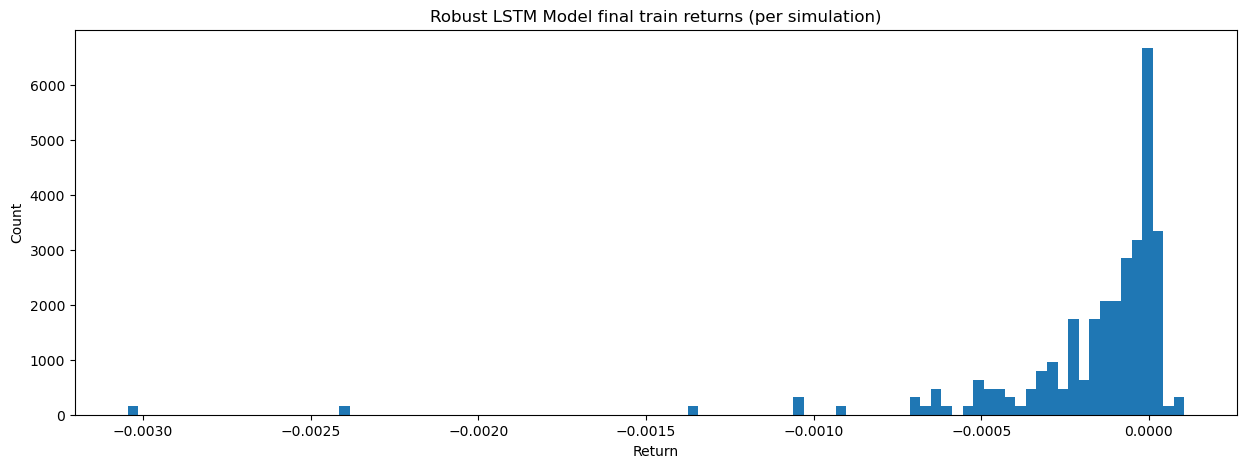

In [229]:
# Train
plt.figure(figsize=(15,5))
plt.hist(RobustLSTMmodel_returns_train, density=True, bins=100)
plt.title("Robust LSTM Model final train returns (per simulation)")
plt.xlabel("Return")
plt.ylabel("Count")
plt.show()

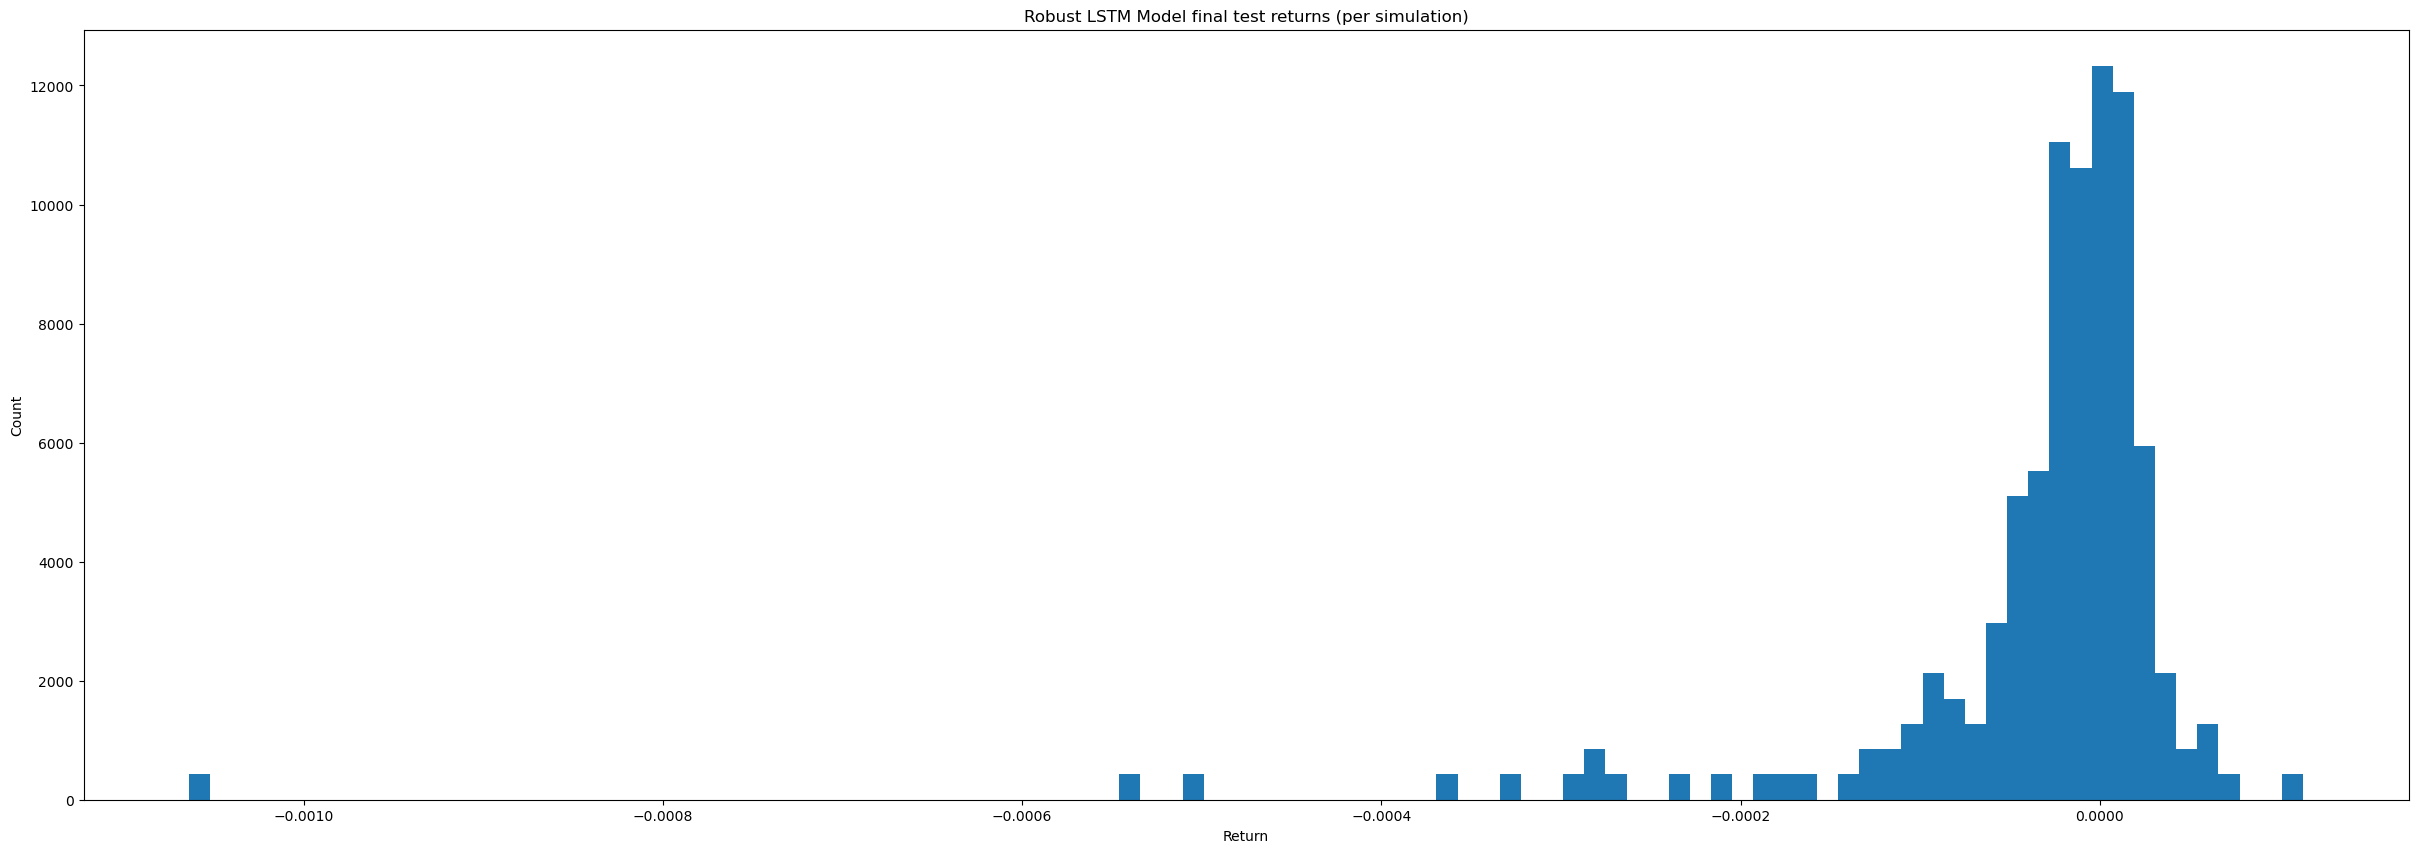

In [230]:
# Test
plt.figure(figsize=(30,10))
plt.hist(RobustLSTMmodel_returns_test, density=True, bins=100)
plt.title("Robust LSTM Model final test returns (per simulation)")
plt.xlabel("Return")
plt.ylabel("Count")
plt.show()

In [231]:
print(tau, a)

20 0


In [233]:
torch.save(RobustLSTMmodel, f'Robustmodelrnn_tau{tau}_a{a}_e20_lr0001_p200tr.pth')

In [234]:

returns = pd.read_csv('rnn_returns.csv')
returns.loc[len(returns)] = [tau, a, RobustLSTMmodel_returns_train, RobustLSTMmodel_returns_test, losses_robu_lstm]
returns.to_csv('rnn_returns.csv', index=False)

In [270]:
import ast
returns = pd.read_csv('lstm_returns.csv')
for col in ['train_returns', 'test_returns', 'loss']:
    returns[col] = returns[col].apply(ast.literal_eval)


In [271]:
returns

,tau,a,train_returns,test_returns,loss
0,20,0,"[-1.664060982875526e-05, -2.3125197913032025e-...","[1.5625013816134015e-07, -7.031222821751726e-0...",0
1,100,10,"[0.0019937290344387293, -0.034396346658468246,...","[7.968803402036428e-06, 0.0009005891042761505,...",0
2,50,0,"[-0.00019615965720731765, -0.00100487389136105...","[-5.390837486629607e-06, -5.155017788638361e-0...",0
3,20,100,"[-9.453052189201117e-05, -0.000130476677441038...","[-2.3437610252585728e-07, -4.687362888944335e-...",0
4,20,10,"[-6.734338967362419e-05, -0.000100863566331099...","[-2.343757472544894e-07, -4.062418611283647e-0...","[0.002146005630493164, 0.0033907294273376465, ..."
5,20,10,"[-6.734338967362419e-05, -0.000100863566331099...","[-2.343757472544894e-07, -4.062418611283647e-0...","[0.002146005630493164, 0.0033907294273376465, ..."
6,100,0,"[0.0015625277301296592, -0.02387102134525776, ...","[1.6797206626506522e-05, 0.0008741904748603702...","[-0.0004094531468581408, 9.688186401035637e-05..."
7,100,100,"[0.001567662344314158, -0.023801958188414574, ...","[1.179720857180655e-05, 0.0008407137356698513,...","[-0.00039206683868542314, 8.330345008289441e-0..."
8,50,10,"[-9.632532601244748e-05, -0.000508789264131337...","[-2.2656658984487876e-06, -6.639889761572704e-...","[0.0005050062900409102, 0.002603590488433838, ..."
9,50,100,"[-0.00013655242219101638, -0.00081844796659424...","[-7.187832579802489e-06, -3.280323653598316e-0...","[0.0005118167609907687, 0.0029539442621171474,..."


In [283]:
returns_l = returns.loc[7,'test_returns']

# Convert the list to a numpy array for calculations
returns_array = np.array(returns_l)

# Mean return
mean_return = np.mean(returns_array)

# VaR at 95% confidence level
var_95 = np.percentile(returns_array, 5)

# CVaR (Expected Shortfall) at 95% confidence level
cvar_95 = np.mean(returns_array[returns_array <= var_95])

# Quartiles (Q1, Q2 (median), Q3)
q1 = np.percentile(returns_array, 25)
median = np.percentile(returns_array, 50)
q3 = np.percentile(returns_array, 75)

# Maximum and Minimum returns
max_return = np.max(returns_array)
min_return = np.min(returns_array)

# Create a dictionary to store the results
results = {
    'Model': 'LSTM_100_100',
    'Mean Return': mean_return,
    'VaR (95%)': var_95,
    'CVaR (95%)': cvar_95,
    'Q1 (25th percentile)': q1,
    'Median (50th percentile)': median,
    'Q3 (75th percentile)': q3,
    'Max Return': max_return,
    'Min Return': min_return
}

# Convert the results to a DataFrame for a cleaner display
results_df.loc[len(results_df)] = results
results_df.head(30)

,Model,Mean Return,VaR (95%),CVaR (95%),Q1 (25th percentile),Median (50th percentile),Q3 (75th percentile),Max Return,Min Return
0,Constant_20,-0.006678,-0.037632,-0.065962,-0.006940,-2.541220e-03,1.364475e-03,0.007901,-0.164441
1,Constant_50,-0.002026,-0.012667,-0.024647,-0.001902,5.081947e-04,1.210872e-03,0.005447,-0.041874
2,Constant_100,-0.000489,-0.005835,-0.011461,-0.000348,2.860575e-04,6.940258e-04,0.007170,-0.025577
3,RNN_100_0,-0.000737,-0.020511,-0.031153,-0.000275,6.922780e-04,2.208264e-03,0.035249,-0.051799
4,RNN_50_0,-0.000174,-0.001759,-0.003130,-0.000296,1.703589e-05,1.980910e-04,0.003140,-0.005378
5,RNN_20_0,-0.000038,-0.000207,-0.000414,-0.000042,-1.093752e-05,8.710697e-06,0.000113,-0.001064
6,LSTM_20_0,-0.000002,-0.000012,-0.000024,-0.000003,-7.031235e-07,4.101559e-07,0.000005,-0.000062
7,LSTM_20_10,-0.000010,-0.000053,-0.000106,-0.000011,-2.851543e-06,1.894510e-06,0.000027,-0.000271
8,LSTM_20_100,-0.000013,-0.000073,-0.000145,-0.000015,-3.242211e-06,2.539059e-06,0.000038,-0.000362
9,LSTM_50_0,-0.000025,-0.000321,-0.000520,-0.000058,4.140630e-06,4.198956e-05,0.000738,-0.000842


In [284]:
results_df.to_csv('Models_summary.csv', index=False)

In [269]:
results_df.head(30)

,Model,Mean Return,VaR (95%),CVaR (95%),Q1 (25th percentile),Median (50th percentile),Q3 (75th percentile),Max Return,Min Return
0,Constant_20,-0.006678,-0.037632,-0.065962,-0.006940,-0.002541,0.001364,0.007901,-0.164441
1,Constant_50,-0.002026,-0.012667,-0.024647,-0.001902,0.000508,0.001211,0.005447,-0.041874
2,Constant_100,-0.000489,-0.005835,-0.011461,-0.000348,0.000286,0.000694,0.007170,-0.025577
3,RNN_100_0,-0.000737,-0.020511,-0.031153,-0.000275,0.000692,0.002208,0.035249,-0.051799
4,RNN_50_0,-0.000174,-0.001759,-0.003130,-0.000296,0.000017,0.000198,0.003140,-0.005378
5,RNN_20_0,-0.000038,-0.000207,-0.000414,-0.000042,-0.000011,0.000009,0.000113,-0.001064
